In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
data=pd.read_csv("C:/건강검진/health_checkup/JDM/최종질병예측/최종_건강검진_데이터셋.csv")

In [3]:
data=pd.read_csv("C:/semi_project/health_checkup/JDM/최종질병예측/최종_건강검진_데이터셋.csv")

**EDA**

In [206]:
data.shape

(19310, 27)

In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19310 entries, 0 to 19309
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           19310 non-null  object 
 1   year         19310 non-null  float64
 2   age          19310 non-null  float64
 3   sex          19310 non-null  float64
 4   HE_ht        19011 non-null  float64
 5   HE_wt        19208 non-null  float64
 6   HE_wc        18373 non-null  float64
 7   HE_BMI       19005 non-null  float64
 8   HE_sbp1      18585 non-null  float64
 9   HE_dbp1      18585 non-null  float64
 10  HE_Upro      17722 non-null  float64
 11  HE_glu       17711 non-null  float64
 12  HE_HbA1c     17676 non-null  float64
 13  HE_chol      17711 non-null  float64
 14  HE_HDL_st2   17710 non-null  float64
 15  HE_TG        17711 non-null  float64
 16  HE_LDL_drct  12790 non-null  float64
 17  HE_crea      17711 non-null  float64
 18  HE_ast       17710 non-null  float64
 19  HE_a

In [5]:
# 분석할 당뇨 관련 컬럼 목록
dm_columns = ['HE_DM_HbA1c']

# 결측치 개수와 비율 계산
for col in dm_columns:
    total = len(data)
    missing = data[col].isna().sum()
    ratio = missing / total * 100
    print(f"{col} 결측치: {missing}개 ({ratio:.2f}%)")


HE_DM_HbA1c 결측치: 4682개 (24.25%)


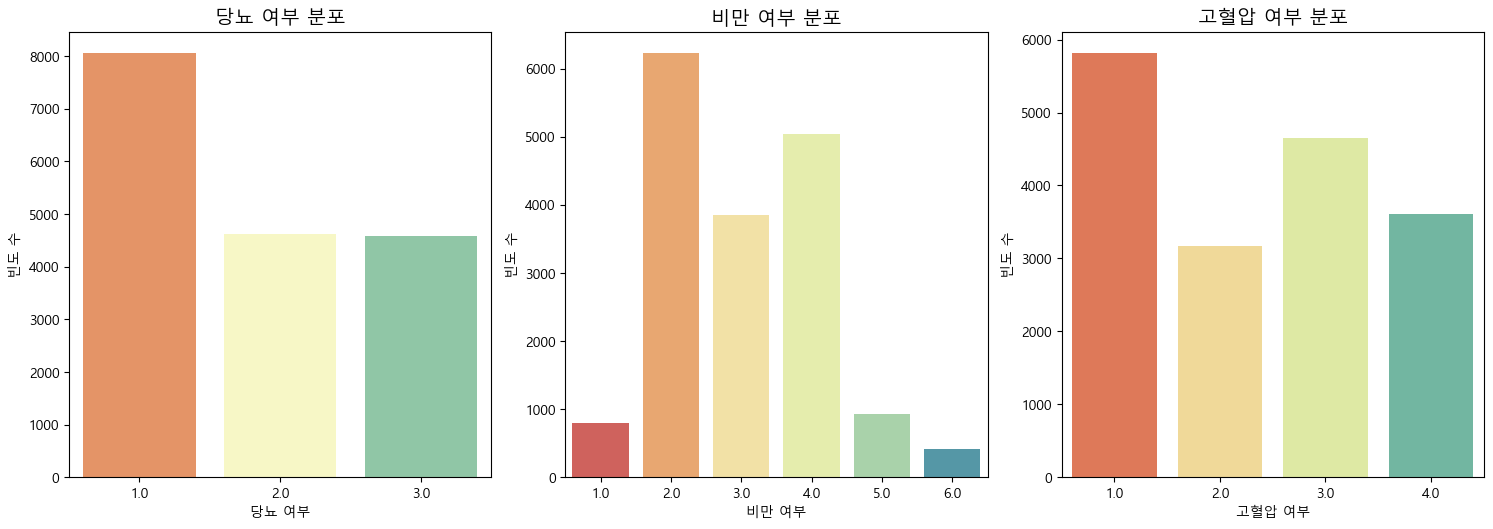

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': '당뇨 여부',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [5]:
# 공복혈당: 50 이상 & 350 이하
data = data[(data['HE_glu'] >= 50) & (data['HE_glu'] <= 350)]

# ALT (간수치): 400 미만
data = data[data['HE_alt'] < 400]

In [4]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu','HE_HbA1c', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg','DE1_pt', 'DI1_pt'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]


In [57]:
# 1. 진단 자체를 안 받은 사람만 필터링
undiagnosed = data[data["DI1_pt"] == 8]

# 2. 각 질병별 분포 확인
print("✅ HE_HP (고혈압 단계) 분포:")
print(undiagnosed["HE_HP"].value_counts().sort_index())
print()

print("✅ HE_obe (비만 단계) 분포:")
print(undiagnosed["HE_obe"].value_counts().sort_index())
print()

print("✅ HE_DM_HbA1c (당뇨 여부) 분포:")
print(undiagnosed["HE_DM_HbA1c"].value_counts().sort_index())

✅ HE_HP (고혈압 단계) 분포:
HE_HP
1.0    5074
2.0    3084
3.0    3186
4.0     722
Name: count, dtype: int64

✅ HE_obe (비만 단계) 분포:
HE_obe
1.0     488
2.0    4646
3.0    2690
4.0    3233
5.0     567
6.0     124
Name: count, dtype: int64

✅ HE_DM_HbA1c (당뇨 여부) 분포:
HE_DM_HbA1c
1.0    5267
2.0    2840
3.0    2038
Name: count, dtype: int64


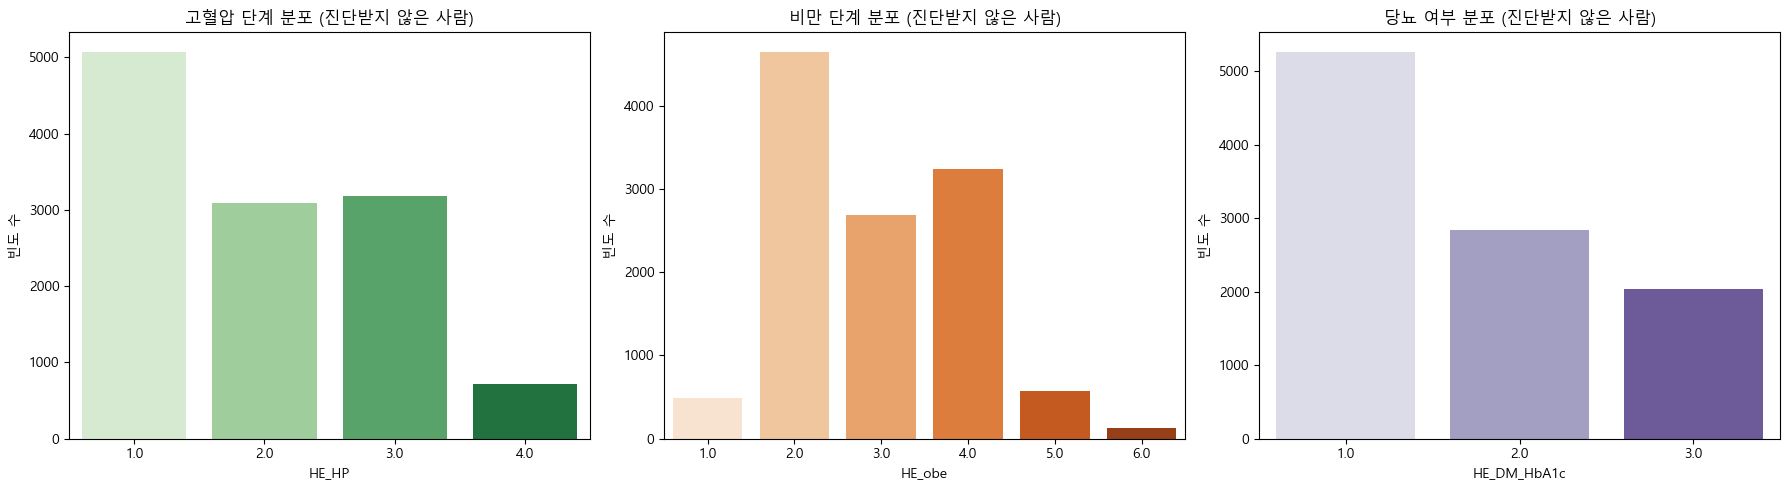

In [58]:
# 코드 실행 환경 초기화로 인해 필요한 라이브러리 재임포트 및 데이터 재정의
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 진단받지 않은 사람만 필터링
undiagnosed = data[data["DI1_pt"] == 8]

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# HE_HP: 고혈압 단계
sns.countplot(x="HE_HP", data=undiagnosed, ax=axes[0], palette="Greens")
axes[0].set_title("고혈압 단계 분포 (진단받지 않은 사람)")
axes[0].set_xlabel("HE_HP")
axes[0].set_ylabel("빈도 수")

# HE_obe: 비만 단계
sns.countplot(x="HE_obe", data=undiagnosed, ax=axes[1], palette="Oranges")
axes[1].set_title("비만 단계 분포 (진단받지 않은 사람)")
axes[1].set_xlabel("HE_obe")
axes[1].set_ylabel("빈도 수")

# HE_DM_HbA1c: 당뇨 여부
sns.countplot(x="HE_DM_HbA1c", data=undiagnosed, ax=axes[2], palette="Purples")
axes[2].set_title("당뇨 여부 분포 (진단받지 않은 사람)")
axes[2].set_xlabel("HE_DM_HbA1c")
axes[2].set_ylabel("빈도 수")

plt.tight_layout()
plt.show()


치료여부 비해당(의사진단 받지 않음) -> 진단자체를 안 받음 -> 치료 받은적 없음 => 각 질병 기준치에 따른 결측치 대체

In [ ]:
import pandas as pd
import numpy as np

# --- HE_DM_HbA1c 결측치 처리 개선 ---

# 1. 9, 99, 999, 888 등을 NaN으로 처리
data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)

# 조건 1-1: DE1_pt 8 (의사 진단 없음) & HE_DM_HbA1c가 NaN & 공복혈당 정상 (70 < HE_glu < 100)
condition_glu_normal = (
    data['DE1_pt'] == 8
) & (
    data['HE_DM_HbA1c'].isnull()
) & (
   (data['HE_glu'] > 70) & data['HE_glu'] < 100
)
data.loc[condition_glu_normal, 'HE_DM_HbA1c'] = 1 # 1: 당뇨 정상
print(f"HE_DM_HbA1c 결측치 중 'DE1_pt=8 & 공복혈당<100' 조건 만족하는 경우 1로 채움. ({condition_glu_normal.sum()}개)")


# 조건 1-2: DE1_pt 8 (의사 진단 없음) & HE_DM_HbA1c가 NaN & 공복혈당장애 (100 <= HE_glu <= 125)
condition_glu_pre_diabetes = (
    data['DE1_pt'] == 8
) & (
    data['HE_DM_HbA1c'].isnull()
) & (
    (data['HE_glu'] >= 100) & (data['HE_glu'] <= 125)
)
data.loc[condition_glu_pre_diabetes, 'HE_DM_HbA1c'] = 2 #당뇨병 전단계
print(f"HE_DM_HbA1c 결측치 중 'DE1_pt=8 & 100<=공복혈당<=125' 조건 만족하는 경우 2로 채움. ({condition_glu_pre_diabetes.sum()}개)")

# 조건 1-3: DE1_pt 0 (의사 진단 없음) & HE_DM_HbA1c가 NaN & 공복혈당 당뇨 >= 126
# 이는 의사 진단은 없지만 공복혈당으로 볼 때 당뇨병으로 의심되는 경우입니다.
condition_glu_diabetes_suspect = (
    data['DE1_pt'] == 8
) & (
    data['HE_DM_HbA1c'].isnull()
) & (
    data['HE_glu'] >= 126
)
data.loc[condition_glu_diabetes_suspect, 'HE_DM_HbA1c'] = 3 # 3: 당뇨병
print(f"HE_DM_HbA1c 결측치 중 'DE1_pt=8 & 공복혈당>=126' 조건 만족하는 경우 3으로 채움. ({condition_glu_diabetes_suspect.sum()}개)")


# 3. 남은 결측치는 드랍하거나 다른 방식으로 처리 (기존과 동일)
#    위에서 정의되지 않은 케이스 (예: HE_glu가 NaN이거나 범위를 벗어나는 경우, 또는 다른 이유로 남은 NaN)
#    이후 모델 학습에 영향을 주지 않도록 처리합니다.
if data['HE_DM_HbA1c'].isnull().any():
    initial_nan_count_after_fill = data['HE_DM_HbA1c'].isnull().sum()
    data = data[data['HE_DM_HbA1c'].notnull()] # 결측치 제거
    print(f"남은 HE_DM_HbA1c 결측치 ({initial_nan_count_after_fill}개) 제거 완료.")
else:
    print("모든 HE_DM_HbA1c 결측치 처리가 완료되었습니다.")

print(f"HE_DM_HbA1c NaN count after all processing: {data['HE_DM_HbA1c'].isnull().sum()}")
print("\nHE_DM_HbA1c 최종 분포:")
print(data['HE_DM_HbA1c'].value_counts(dropna=False))

HE_DM_HbA1c 결측치 중 'DE1_pt=8 & 공복혈당<100' 조건 만족하는 경우 1로 채움. (2140개)
HE_DM_HbA1c 결측치 중 'DE1_pt=8 & 100<=공복혈당<=125' 조건 만족하는 경우 2로 채움. (639개)
HE_DM_HbA1c 결측치 중 'DE1_pt=8 & 공복혈당>=126' 조건 만족하는 경우 3으로 채움. (101개)
남은 HE_DM_HbA1c 결측치 (1802개) 제거 완료.
HE_DM_HbA1c NaN count after all processing: 0

HE_DM_HbA1c 최종 분포:
HE_DM_HbA1c
1.0    8205
2.0    4685
3.0    4618
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np


# --- HE_HP 결측치 처리 개선 (수정된 코드) ---

# 1. 9, 99, 999, 888 등을 NaN으로 처리
data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)


# 조건 1-1: DI1_pt 8 (의사 진단 없음) & HE_HP NaN & 수축기,이완기 혈압 정상
condition_hp_normal = (
    data['DI1_pt'] == 8 # 이 부분을 'DE1_dg'로 사용하려면 data['DE1_dg'] == 0 으로 변경
) & (
    data['HE_HP'].isnull()
) & (
    data['HE_sbp1'] < 120
) & (
    data['HE_dbp1'] < 80
) 

# !!! 중요: 여기 변수명을 올바른 것으로 수정 !!!
data.loc[condition_hp_normal, 'HE_HP'] = 1 # 1: 혈압 정상
print(f"HE_HP 결측치 중 'DI1_pt=8 & 혈압/콜레스테롤/BMI/혈당 정상 조건 만족'하는 경우 1로 채움. ({condition_hp_normal.sum()}개)")


# 조건 1-2: DI1_pt 8 (의사 진단 없음) & HE_HP NaN & 수축기,이완기 혈압 '주의 혈압' 범위
condition_hp_pre_attention = (
    data['DI1_pt'] == 8
) & (
    data['HE_HP'].isnull()
) & (
    (data['HE_sbp1'] >= 120) & (data['HE_sbp1'] < 130) & (data['HE_dbp1'] < 80)
)
data.loc[condition_hp_pre_attention, 'HE_HP'] = 2 # 2: 주의 혈압
print(f"HE_HP 결측치 중 'DI1_pt=8 & 120<=수축기<130 & 이완기<80' 조건 만족하는 경우 2로 채움. ({condition_hp_pre_attention.sum()}개)")


# 조건 1-3: DI1_pt 8 (의사 진단 없음) & HE_HP NaN & 수축기,이완기 혈압 '고혈압 전단계' 범위
condition_hp_pre_hypertension = (
    data['DI1_pt'] == 8
) & (
    data['HE_HP'].isnull()
) & (
    (data['HE_sbp1'] >= 130) & (data['HE_sbp1'] < 140) & (data['HE_dbp1'] < 90)
)
data.loc[condition_hp_pre_hypertension, 'HE_HP'] = 3 # 3: 고혈압 전단계
print(f"HE_HP 결측치 중 'DI1_pt=8 & 130<=수축기<140 & 이완기<90' 조건 만족하는 경우 3로 채움. ({condition_hp_pre_hypertension.sum()}개)")


# 조건 1-4: DI1_pt 8 (의사 진단 없음) & HE_HP NaN & 수축기,이완기 혈압 '고혈압' 범위
condition_hp_hypertension = (
    data['DI1_pt'] == 8
) & (
    data['HE_HP'].isnull()
) & (
    (data['HE_sbp1'] >= 140) | (data['HE_dbp1'] >= 90)
)
# !!! 중요: 여기 변수명을 올바른 것으로 수정 !!!
data.loc[condition_hp_hypertension, 'HE_HP'] = 4 # 4: 고혈압
print(f"HE_HP 결측치 중 'DI1_pt=8 & (수축기>=140 또는 이완기>=90)' 조건 만족하는 경우 4로 채움. ({condition_hp_hypertension.sum()}개)")


# 3. 남은 결측치는 드랍하거나 다른 방식으로 처리
#    위에서 정의되지 않은 케이스 (예: DI1_pt가 8이 아니거나, 혈압/콜레스테롤 등 지표가 NaN인 경우 등)
if data['HE_HP'].isnull().any():
    initial_nan_count_after_fill = data['HE_HP'].isnull().sum()
    data = data[data['HE_HP'].notnull()].copy() # .copy()를 추가하여 SettingWithCopyWarning 방지
    print(f"남은 HE_HP 결측치 ({initial_nan_count_after_fill}개) 제거 완료.")
else:
    print("모든 HE_HP 결측치 처리가 완료되었습니다.")

print(f"\nHE_HP NaN count after all processing: {data['HE_HP'].isnull().sum()}")
print("\nHE_HP 최종 분포:")
print(data['HE_HP'].value_counts(dropna=False))

HE_HP 결측치 중 'DI1_pt=8 & 혈압/콜레스테롤/BMI/혈당 정상 조건 만족'하는 경우 1로 채움. (678개)
HE_HP 결측치 중 'DI1_pt=8 & 120<=수축기<130 & 이완기<80' 조건 만족하는 경우 2로 채움. (104개)
HE_HP 결측치 중 'DI1_pt=8 & 130<=수축기<140 & 이완기<90' 조건 만족하는 경우 3로 채움. (33개)
HE_HP 결측치 중 'DI1_pt=8 & (수축기>=140 또는 이완기>=90)' 조건 만족하는 경우 4로 채움. (10개)
남은 HE_HP 결측치 (249개) 제거 완료.

HE_HP NaN count after all processing: 0

HE_HP 최종 분포:
HE_HP
1.0    5814
3.0    4654
4.0    3615
2.0    3176
Name: count, dtype: int64


In [6]:
# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

HE_obe NaN count after: 0


In [7]:
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'HE_HbA1c'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data


print("결측치 처리 후 데이터 상태:")
print(data.isnull().sum())
print("\n타겟 변수 클래스 비율:")
for target in ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']:
    if target in data.columns:
        print(f"\n{target}:\n{data[target].value_counts(normalize=True)}")
print("\n기본 통계량:")
print(data.describe())

# 전처리 코드 끝에 추가
data.to_csv("최종_건강검진_데이터셋(가공된).csv", index=False, encoding='utf-8-sig')

Median for HE_wt: 62.9
Median for HE_ht: 162.7
Median for HE_BMI: 23.872117440478384
결측치 처리 후 데이터 상태:
ID                0
year              0
age               0
sex               0
HE_ht             0
HE_wt             0
HE_wc             0
HE_BMI            0
HE_sbp1           0
HE_dbp1           0
HE_Upro           0
HE_glu            0
HE_HbA1c          0
HE_chol           0
HE_HDL_st2        0
HE_TG             0
HE_LDL_drct       0
HE_crea           0
HE_ast            0
HE_alt            0
HE_obe            0
HE_HP             0
HE_DM_HbA1c       0
DE1_dg            0
DI1_dg            0
DE1_pt            0
DI1_pt            0
HE_BMI_imputed    0
dtype: int64

타겟 변수 클래스 비율:

HE_DM_HbA1c:
HE_DM_HbA1c
1.0    0.466771
2.0    0.267860
3.0    0.265369
Name: proportion, dtype: float64

HE_obe:
HE_obe
2.0    0.360855
4.0    0.291790
3.0    0.222782
5.0    0.054001
1.0    0.046584
6.0    0.023987
Name: proportion, dtype: float64

HE_HP:
HE_HP
1.0    0.336868
3.0    0.269656
4.0    0.209

In [5]:
# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")


# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")

print("\HE_HP 최종 분포:")
print(data['HE_HP'].value_counts(dropna=False))

continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'HE_HbA1c'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data

# knn_scaler_filename = 'HE_DM_HbA1c_knn_scaler.pkl'
# knn_imputer_filename = 'HE_DM_HbA1c_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)
# knn_scaler_filename = 'HE_obe_knn_scaler.pkl'
# knn_imputer_filename = 'HE_obe_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)
# knn_scaler_filename = 'HE_HP_knn_scaler.pkl'
# knn_imputer_filename = 'HE_HP_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)

print("결측치 처리 후 데이터 상태:")
print(data.isnull().sum())
print("\n타겟 변수 클래스 비율:")
for target in ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']:
    if target in data.columns:
        print(f"\n{target}:\n{data[target].value_counts(normalize=True)}")
print("\n기본 통계량:")
print(data.describe())

# 전처리 코드 끝에 추가
#data.to_csv('건강조사_2022~2023_통합(가공된).csv', index=False, encoding='utf-8-sig')

DE1_dg missing ratio: 0.0004660797514241326
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
\HE_HP 최종 분포:
HE_HP
1.0    5442
3.0    4738
4.0    3852
2.0    3106
Name: count, dtype: int64
Median for HE_wt: 63.2
Median for HE_ht: 162.7
Median for HE_BMI: 23.98917739031172
결측치 처리 후 데이터 상태:
ID                0
year              0
age               0
sex               0
HE_ht             0
HE_wt             0
HE_wc             0
HE_BMI            0
HE_sbp1           0
HE_dbp1           0
HE_Upro           0
HE_glu            0
HE_HbA1c          0
HE_chol           0
HE_HDL_st2        0
HE_TG             0
HE_LDL_drct       0
HE_crea           0
HE_ast            0
HE_alt            0
HE_obe            0
HE_HP             0
HE_DM_HbA1c       0
DE1_dg            0
DI1_dg            0
DE1_pt            0
DI1_pt            0
HE_BMI_imputed    0
dtype: int64

타겟 변수 클래스 비율:

HE_DM_HbA1c:
HE_DM_HbA1c
1.0    0.484070
3.0    0.279846
2.0    

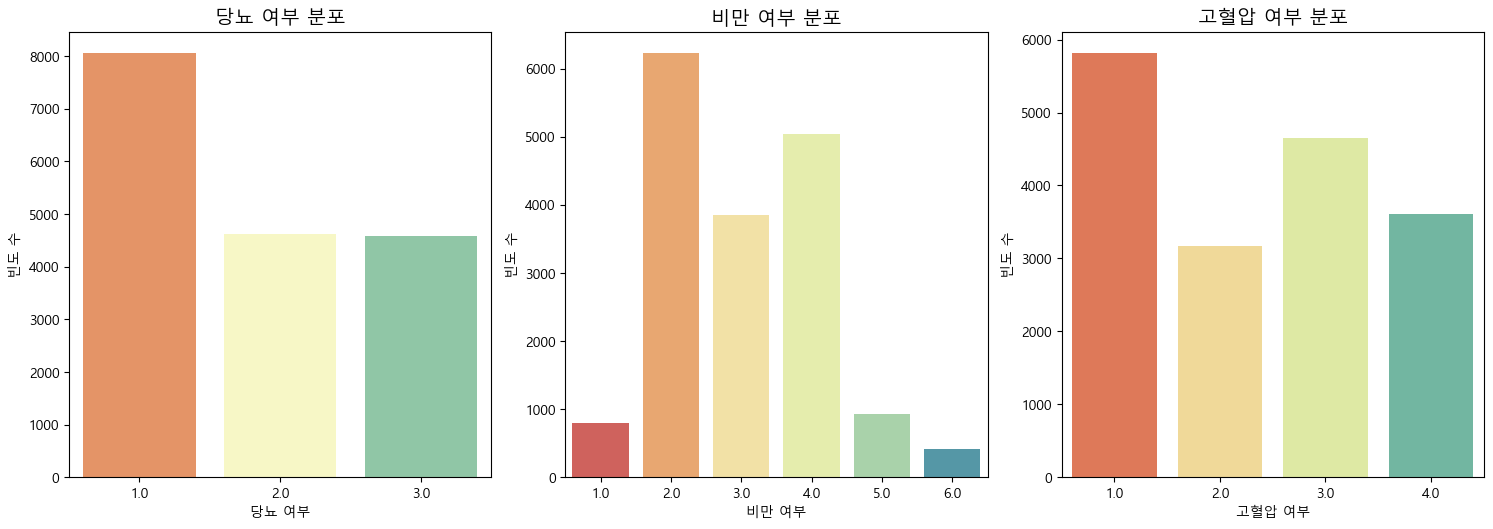

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': '당뇨 여부',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


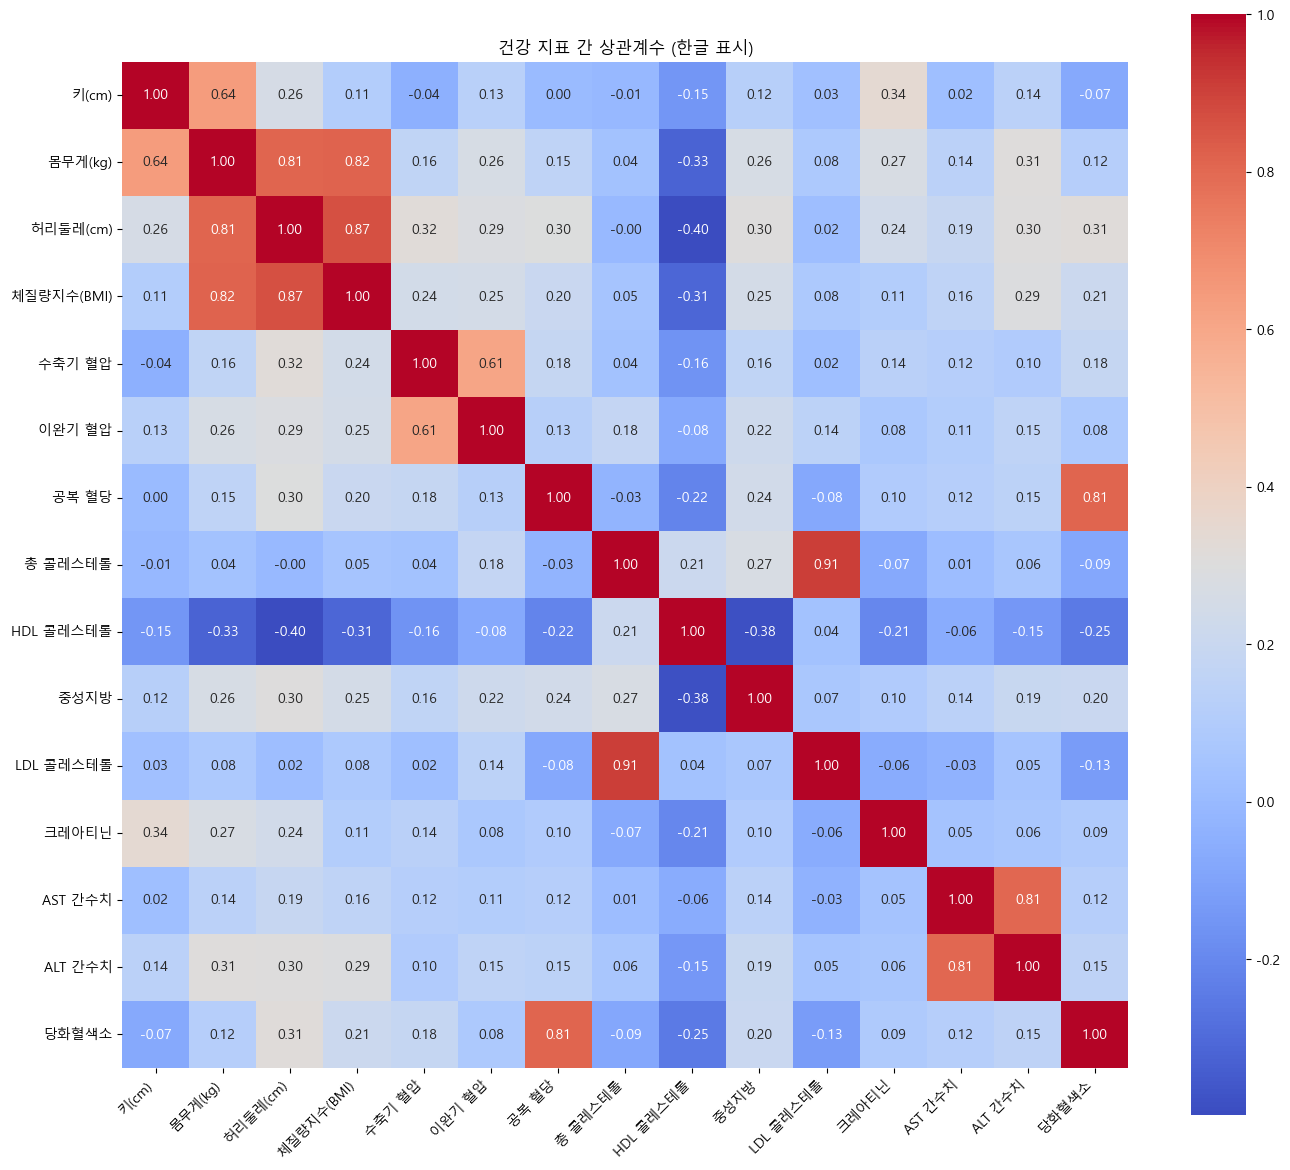

In [150]:
column_name_map = {
    'HE_ht': '키(cm)',
    'HE_wt': '몸무게(kg)',
    'HE_wc': '허리둘레(cm)',
    'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_glu': '공복 혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST 간수치',
    'HE_alt': 'ALT 간수치',
    'HE_HbA1c' : '당화혈색소'
}


correlation_columns = [
    'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1', 'HE_glu', 'HE_chol', 'HE_HDL_st2', 'HE_HbA1c'
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'DE1_3', 'DI1_pt'
]

import seaborn as sns
import matplotlib.pyplot as plt

# 보고 싶은 변수만 추출
selected_columns = list(column_name_map.keys())
correlation_matrix = data[selected_columns].corr()

# 컬럼명을 한글로 변환
correlation_matrix.columns = [column_name_map[col] for col in correlation_matrix.columns]
correlation_matrix.index = [column_name_map[col] for col in correlation_matrix.index]

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("건강 지표 간 상관계수 (한글 표시)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# 영어 → 한글 맵핑
column_name_map = {
    'age': '나이',
    'HE_ht': '키(cm)', 'HE_wt': '몸무게(kg)', 'HE_wc': '허리둘레(cm)', 'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백', 'HE_glu': '공복 혈당', 'HE_HbA1c': '당화혈색소',
    'HE_chol': '총 콜레스테롤', 'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST 간수치', 'HE_alt': 'ALT 간수치'
}

# 분석 대상 수치형 피처
num_features = list(column_name_map.keys())

# 입력(X), 타겟(y)
X = data[num_features]
y = data["HE_HP"]  # 고혈압 여부

# 상호정보량 계산
mi = mutual_info_classif(X, y, discrete_features=False, random_state=0)

# 인덱스를 '영문(한글)' 형식으로 정리
display_names = [f"{col} ({column_name_map[col]})" for col in num_features]
mi_series = pd.Series(mi, index=display_names).sort_values(ascending=False)

# 출력
print("🔍 고혈압 관련 변수 중요도 (Mutual Information 기준):\n")
print(mi_series)


🔍 고혈압 관련 변수 중요도 (Mutual Information 기준):

HE_sbp1 (수축기 혈압)           0.498769
HE_dbp1 (이완기 혈압)           0.243271
HE_LDL_drct (LDL 콜레스테롤)    0.168114
age (나이)                   0.113568
HE_wc (허리둘레(cm))           0.063934
HE_HbA1c (당화혈색소)           0.063804
HE_glu (공복 혈당)             0.049954
HE_BMI (체질량지수(BMI))        0.041385
HE_ast (AST 간수치)           0.035967
HE_alt (ALT 간수치)           0.030820
HE_HDL_st2 (HDL 콜레스테롤)     0.030170
HE_TG (중성지방)               0.026088
HE_chol (총 콜레스테롤)          0.018640
HE_ht (키(cm))              0.018325
HE_crea (크레아티닌)            0.016663
HE_wt (몸무게(kg))            0.010097
HE_Upro (소변 단백)            0.002532
dtype: float64


In [8]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# 영어 → 한글 맵핑
column_name_map = {
    'age': '나이',
    'HE_ht': '키(cm)', 'HE_wt': '몸무게(kg)', 'HE_wc': '허리둘레(cm)', 'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백', 'HE_glu': '공복 혈당', 'HE_HbA1c': '당화혈색소',
    'HE_chol': '총 콜레스테롤', 'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST 간수치', 'HE_alt': 'ALT 간수치'
}

# 분석 대상 수치형 피처
num_features = list(column_name_map.keys())

# 입력(X), 타겟(y)
X = data[num_features]
y = data["HE_DM_HbA1c"]  # 고혈압 여부

# 상호정보량 계산
mi = mutual_info_classif(X, y, discrete_features=False, random_state=0)

# 인덱스를 '영문(한글)' 형식으로 정리
display_names = [f"{col} ({column_name_map[col]})" for col in num_features]
mi_series = pd.Series(mi, index=display_names).sort_values(ascending=False)

# 출력
print("🔍 당뇨병 관련 변수 중요도 (Mutual Information 기준):\n")
print(mi_series)


🔍 당뇨병 관련 변수 중요도 (Mutual Information 기준):

HE_HbA1c (당화혈색소)           0.530560
HE_glu (공복 혈당)             0.469705
HE_LDL_drct (LDL 콜레스테롤)    0.110376
age (나이)                   0.099317
HE_wc (허리둘레(cm))           0.077431
HE_HDL_st2 (HDL 콜레스테롤)     0.057577
HE_chol (총 콜레스테롤)          0.048504
HE_sbp1 (수축기 혈압)           0.043492
HE_BMI (체질량지수(BMI))        0.042277
HE_alt (ALT 간수치)           0.040888
HE_ast (AST 간수치)           0.035510
HE_crea (크레아티닌)            0.027333
HE_TG (중성지방)               0.024971
HE_dbp1 (이완기 혈압)           0.022281
HE_Upro (소변 단백)            0.013389
HE_wt (몸무게(kg))            0.011143
HE_ht (키(cm))              0.010322
dtype: float64


In [9]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# 영어 → 한글 맵핑
column_name_map = {
    'age': '나이',
    'HE_ht': '키(cm)', 'HE_wt': '몸무게(kg)', 'HE_wc': '허리둘레(cm)', 'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백', 'HE_glu': '공복 혈당', 'HE_HbA1c': '당화혈색소',
    'HE_chol': '총 콜레스테롤', 'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST 간수치', 'HE_alt': 'ALT 간수치'
}

# 분석 대상 수치형 피처
num_features = list(column_name_map.keys())

# 입력(X), 타겟(y)
X = data[num_features]
y = data["HE_obe"]  # 고혈압 여부

# 상호정보량 계산
mi = mutual_info_classif(X, y, discrete_features=False, random_state=0)

# 인덱스를 '영문(한글)' 형식으로 정리
display_names = [f"{col} ({column_name_map[col]})" for col in num_features]
mi_series = pd.Series(mi, index=display_names).sort_values(ascending=False)

# 출력
print("🔍 당뇨병 관련 변수 중요도 (Mutual Information 기준):\n")
print(mi_series)


🔍 당뇨병 관련 변수 중요도 (Mutual Information 기준):

HE_BMI (체질량지수(BMI))        1.408993
HE_wc (허리둘레(cm))           0.578330
HE_wt (몸무게(kg))            0.433744
HE_alt (ALT 간수치)           0.063728
HE_ht (키(cm))              0.060859
HE_HDL_st2 (HDL 콜레스테롤)     0.055260
HE_TG (중성지방)               0.048259
HE_sbp1 (수축기 혈압)           0.042397
HE_glu (공복 혈당)             0.041735
HE_dbp1 (이완기 혈압)           0.036799
HE_HbA1c (당화혈색소)           0.024695
age (나이)                   0.024434
HE_ast (AST 간수치)           0.023991
HE_LDL_drct (LDL 콜레스테롤)    0.017588
HE_crea (크레아티닌)            0.012959
HE_Upro (소변 단백)            0.009755
HE_chol (총 콜레스테롤)          0.000000
dtype: float64


In [151]:
from sklearn.feature_selection import mutual_info_classif


num_features = [
    'age','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu','HE_HbA1c', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt'
]

X = data[num_features]  # 수치형 입력 피처
y = data["HE_HP"]

mi = mutual_info_classif(X, y, discrete_features=False)
mi_series = pd.Series(mi, index=num_features).sort_values(ascending=False)
print(mi_series)


HE_sbp1        0.519383
HE_dbp1        0.260264
HE_LDL_drct    0.193934
age            0.120814
HE_wc          0.080332
HE_HbA1c       0.078789
HE_glu         0.055892
HE_ast         0.053137
HE_BMI         0.050448
HE_alt         0.036308
HE_HDL_st2     0.035815
HE_TG          0.028499
HE_ht          0.019221
HE_wt          0.018951
HE_crea        0.016452
HE_chol        0.010157
HE_Upro        0.007023
dtype: float64


상위 6개만 하려했더니 대한고혈압학회 기준에 공복혈당이 126이상이면 고혈압 위험도 증가라 했기에 포함시킴

In [152]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

num_features = [
    'age','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu','HE_HbA1c', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt'
]

# 🎯 X: 수치형 입력 피처들 / y: 범주형 타겟
X = data[num_features]  # 수치형 피처 리스트로 대체 필요
y = data['HE_HP'].astype(int)  # 범주형 타겟 (고혈압 단계)

# 🔍 Mutual Information 계산
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# 📊 결과를 시리즈로 변환하고 정렬
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# ✅ 상위 6개 피처 출력
top_6_features = mi_series.head(6)
print("🎯 Mutual Information 기반 상위 6개 피처:\n")
print(top_6_features)


🎯 Mutual Information 기반 상위 6개 피처:

HE_sbp1        0.525864
HE_dbp1        0.255809
HE_LDL_drct    0.192247
age            0.126140
HE_wc          0.082582
HE_HbA1c       0.066162
dtype: float64


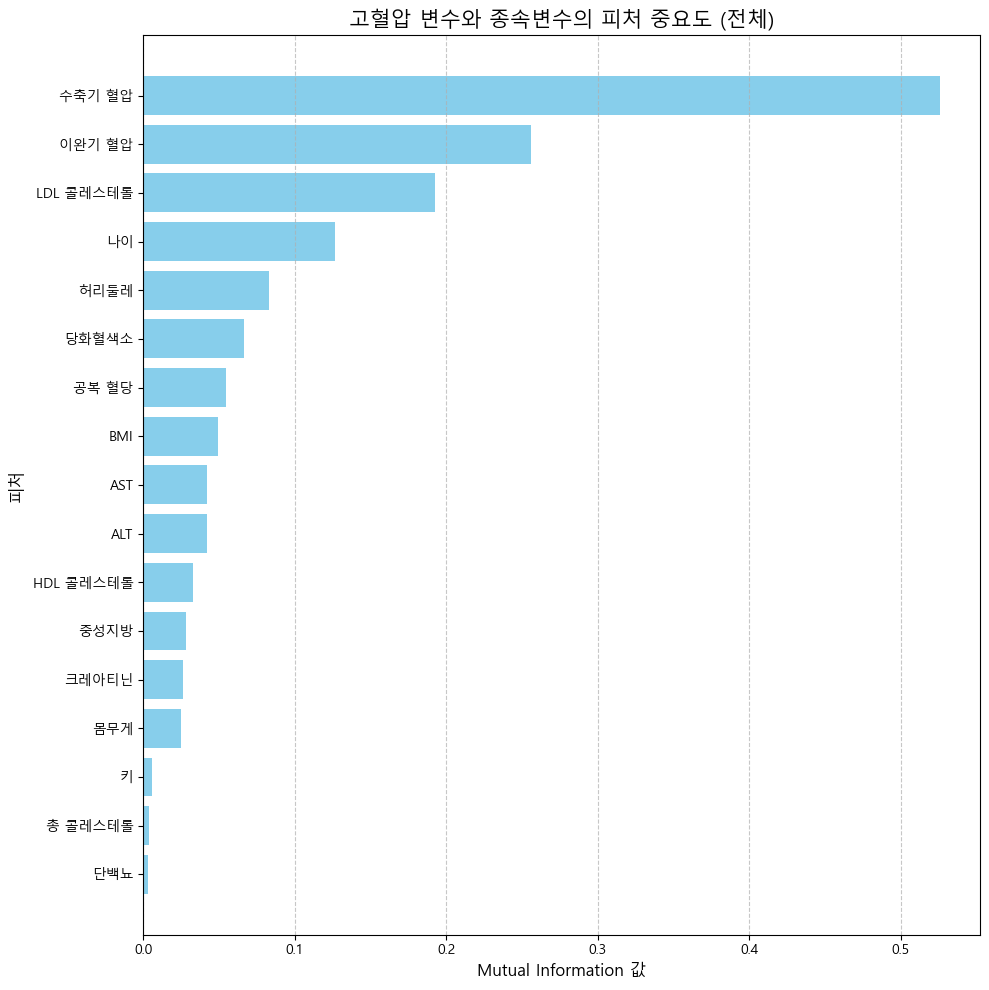

In [55]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm



num_features = [
    'age','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu','HE_HbA1c', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt'
]

# 🎯 X: 수치형 입력 피처들 / y: 범주형 타겟
X = data[num_features]
y = data['HE_HP'].astype(int) # 범주형 타겟 (고혈압 단계)

# 🔍 Mutual Information 계산
# discrete_features=False는 모든 피처를 연속형으로 간주하도록 합니다.
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# 📊 결과를 시리즈로 변환하고 정렬
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# 한글 피처 이름 매핑 (전체 피처에 대해 정의)
korean_feature_names = {
    'age': '나이',
    'HE_ht': '키',
    'HE_wt': '몸무게',
    'HE_wc': '허리둘레',
    'HE_BMI': 'BMI',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_Upro': '단백뇨',
    'HE_glu': '공복 혈당',
    'HE_HbA1c': '당화혈색소',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST',
    'HE_alt': 'ALT'
}

# 모든 피처의 한글 이름 가져오기 (정렬된 순서대로)
all_korean_features = [korean_feature_names[col] for col in mi_series.index]

plt.figure(figsize=(10, 10)) # 모든 피처를 표시하기 위해 세로 크기를 늘림
plt.barh(all_korean_features, mi_series.values, color='skyblue')
plt.xlabel('Mutual Information 값', fontsize=12)
plt.ylabel('피처', fontsize=12)
plt.title('고혈압 변수와 종속변수의 피처 중요도 (전체)', fontsize=15)
plt.gca().invert_yaxis() # 가장 높은 값을 위로 오게 하기 위해 Y축 반전
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [153]:
from sklearn.feature_selection import mutual_info_classif


num_features = [
    'age','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu','HE_HbA1c', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt'
]

X = data[num_features]  # 수치형 입력 피처
y = data["HE_DM_HbA1c"]

mi = mutual_info_classif(X, y, discrete_features=False)
mi_series = pd.Series(mi, index=num_features).sort_values(ascending=False)
print(mi_series)


HE_glu         0.612330
HE_HbA1c       0.562297
age            0.131435
HE_LDL_drct    0.098591
HE_wc          0.094059
HE_BMI         0.057824
HE_HDL_st2     0.043053
HE_sbp1        0.041310
HE_chol        0.039829
HE_TG          0.038403
HE_alt         0.034254
HE_ast         0.033559
HE_dbp1        0.022479
HE_crea        0.019128
HE_Upro        0.014478
HE_ht          0.013268
HE_wt          0.009715
dtype: float64


In [154]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

num_features = [
    'age','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu','HE_HbA1c', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt'
]

# 🎯 X: 수치형 입력 피처들 / y: 범주형 타겟
X = data[num_features]  # 수치형 피처 리스트로 대체 필요
y = data['HE_DM_HbA1c'].astype(int)  # 범주형 타겟 (고혈압 단계)

# 🔍 Mutual Information 계산
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# 📊 결과를 시리즈로 변환하고 정렬
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# ✅ 상위 6개 피처 출력
top_6_features = mi_series.head(6)
print("🎯 Mutual Information 기반 상위 6개 피처:\n")
print(top_6_features)


🎯 Mutual Information 기반 상위 6개 피처:

HE_glu         0.616670
HE_HbA1c       0.562058
age            0.115624
HE_wc          0.103176
HE_LDL_drct    0.098337
HE_BMI         0.057854
dtype: float64


In [155]:
from sklearn.feature_selection import mutual_info_classif


num_features = [
    'age','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu','HE_HbA1c', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt'
]

X = data[num_features]  # 수치형 입력 피처
y = data["HE_obe"]

mi = mutual_info_classif(X, y, discrete_features=False)
mi_series = pd.Series(mi, index=num_features).sort_values(ascending=False)
print(mi_series)


HE_BMI         1.348396
HE_wc          0.599870
HE_wt          0.436432
HE_alt         0.077292
HE_ht          0.055991
age            0.054890
HE_TG          0.052006
HE_glu         0.051261
HE_sbp1        0.051117
HE_HDL_st2     0.050942
HE_HbA1c       0.041740
HE_dbp1        0.033883
HE_ast         0.030055
HE_crea        0.026192
HE_LDL_drct    0.016429
HE_chol        0.012579
HE_Upro        0.009398
dtype: float64


In [156]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# 🎯 X: 수치형 입력 피처들 / y: 범주형 타겟
X = data[num_features]  # 수치형 피처 리스트로 대체 필요
y = data['HE_obe'].astype(int)  # 범주형 타겟 (고혈압 단계)

# 🔍 Mutual Information 계산
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# 📊 결과를 시리즈로 변환하고 정렬
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# ✅ 상위 6개 피처 출력
top_6_features = mi_series.head(6)
print("🎯 Mutual Information 기반 상위 6개 피처:\n")
print(top_6_features)


🎯 Mutual Information 기반 상위 6개 피처:

HE_BMI        1.348336
HE_wc         0.603457
HE_wt         0.444875
HE_alt        0.077310
HE_HDL_st2    0.061245
HE_TG         0.059272
dtype: float64



▶ Mean F1 score (CV) of D_tree: 93.19%
▶ Test F1 score of D_tree: 93.50%
▶ Test Accuracy of D_tree: 93.42%

▶ Mean F1 score (CV) of RF: 93.83%
▶ Test F1 score of RF: 93.90%
▶ Test Accuracy of RF: 93.83%

▶ Mean F1 score (CV) of HistGB: 93.73%
▶ Test F1 score of HistGB: 94.29%
▶ Test Accuracy of HistGB: 94.24%

▶ Mean F1 score (CV) of XGB: 93.46%
▶ Test F1 score of XGB: 94.43%
▶ Test Accuracy of XGB: 94.38%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 11045, number of used features: 6
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` t

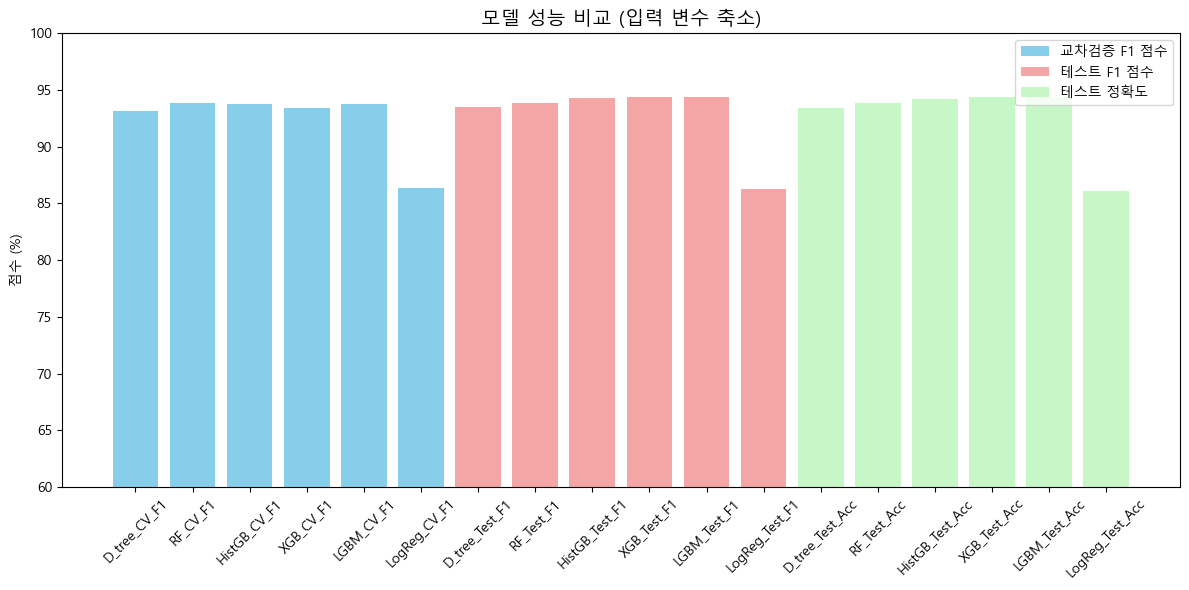

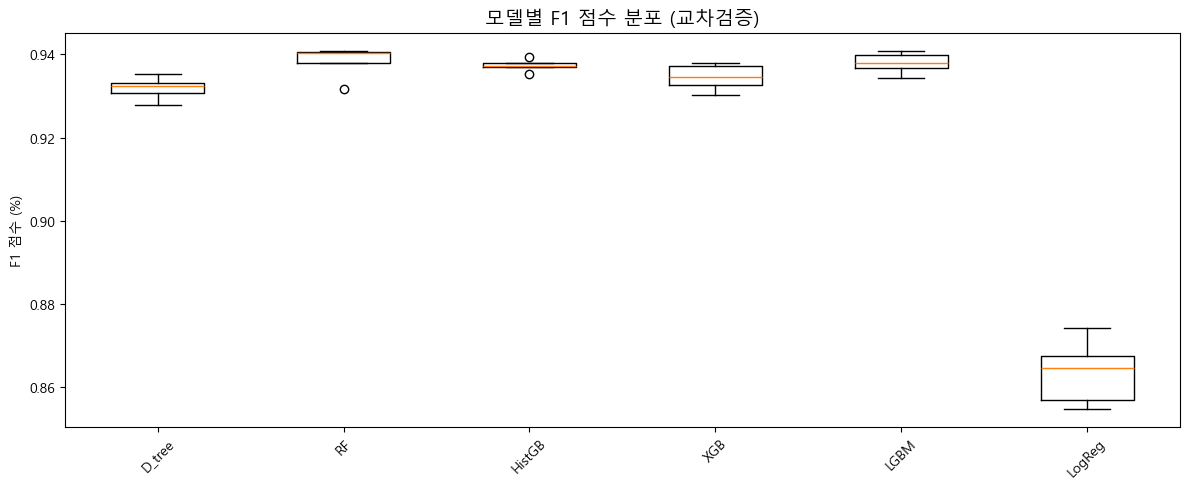

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt



# 입력 피처 및 타겟 설정
HE_DM_HbA1c_input_features = ['HE_glu','HE_HbA1c', 'HE_wc', 'HE_BMI', 'HE_LDL_drct', 'age']
X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 바 차트 (CV, Test F1, Test Accuracy)
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='교차검증 F1 점수')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='테스트 F1 점수', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='테스트 정확도', alpha=0.5)

plt.xticks(rotation=45)
plt.ylabel('점수 (%)')
plt.title('모델 성능 비교 (입력 변수 축소)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot (CV F1 분포)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 점수 (%)')
ax.set_title('모델별 F1 점수 분포 (교차검증)', fontsize=14)
plt.tight_layout()
plt.show()


✅ 고려 요소 정리
- 다중 클래스 분류 (질병 단계 1~4)
- 수치형 피처 중심 → 실제 질병과 높은 상관
- 소수 클래스 존재 + 과적합 방지 필요


📌 HistGradientBoosting Classification Report:

              precision    recall  f1-score   support

          정상       0.99      0.97      0.98      1611
      경계형 당뇨       0.86      0.96      0.91       925
          당뇨       0.95      0.89      0.92       916

    accuracy                           0.94      3452
   macro avg       0.94      0.94      0.94      3452
weighted avg       0.95      0.94      0.94      3452



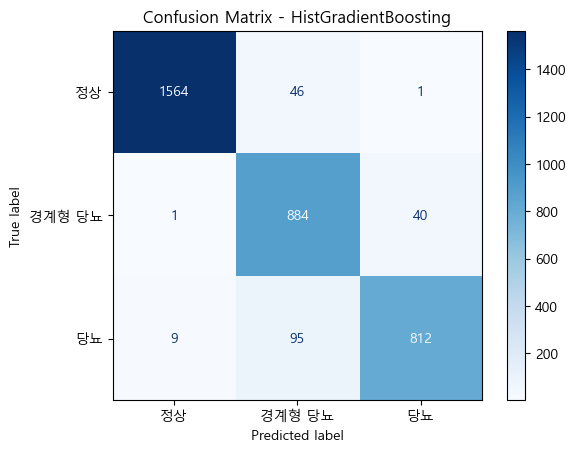


📌 XGBoost Classification Report:

              precision    recall  f1-score   support

          정상       0.99      0.97      0.98      1611
      경계형 당뇨       0.86      0.94      0.90       925
          당뇨       0.94      0.89      0.92       916

    accuracy                           0.94      3452
   macro avg       0.93      0.93      0.93      3452
weighted avg       0.94      0.94      0.94      3452



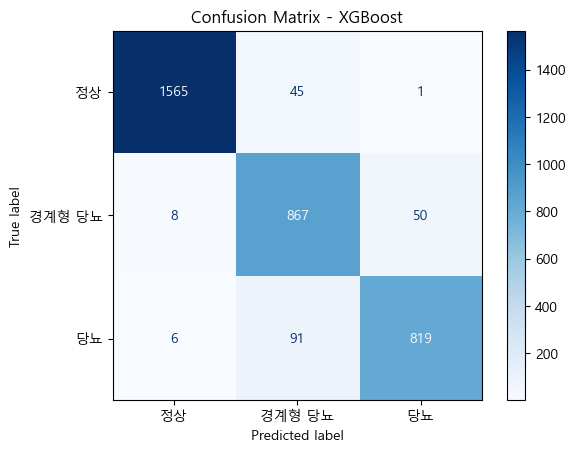


📌 RandomForest Classification Report:

              precision    recall  f1-score   support

          정상       0.99      0.97      0.98      1611
      경계형 당뇨       0.86      0.95      0.90       925
          당뇨       0.95      0.89      0.92       916

    accuracy                           0.94      3452
   macro avg       0.94      0.94      0.94      3452
weighted avg       0.95      0.94      0.94      3452



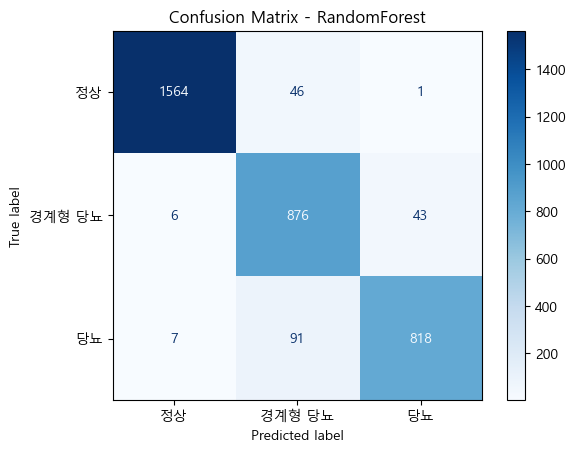

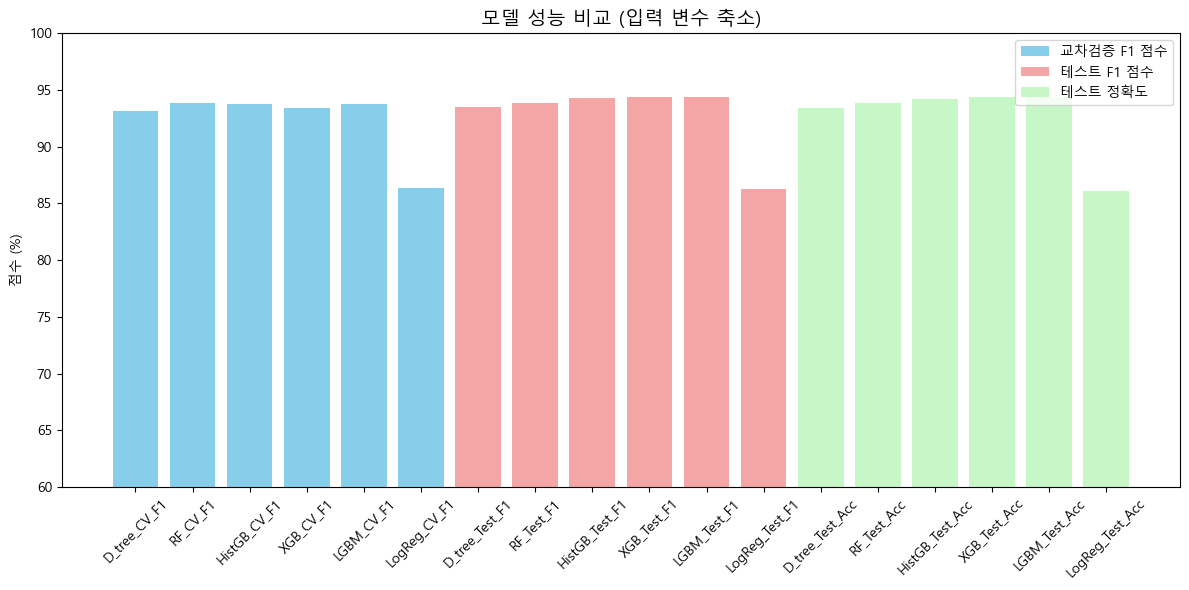

  0%|          | 0/100 [00:00<?, ?it/s]

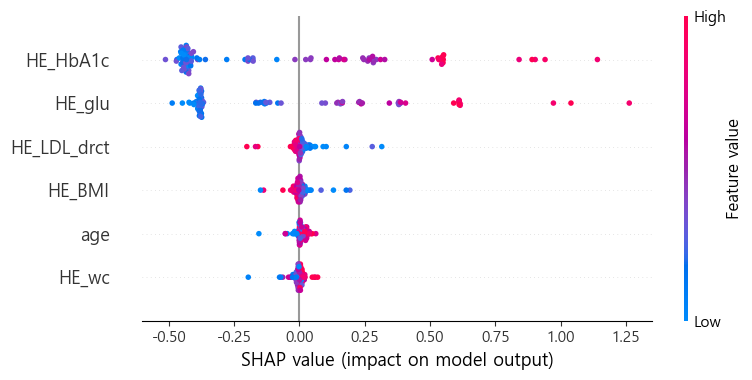

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# 🎯 사용할 피처와 타겟
features = ['HE_glu(공복혈당)','HE_HbA1c(당화혈색소)', 'HE_wc(허리둘레)', 'HE_BMI', 'HE_LDL_drct(LDL콜레스테롤)', 'age']
X = data[features]
y = data['HE_DM_HbA1c(당뇨병유무)'].astype(int) - 1  # 0: 정상, 1: 경계형, 2: 당뇨

# ⚙️ 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 🔧 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 📦 모델 정의
models = {
    "HistGradientBoosting": HistGradientBoostingClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softprob', num_class=3, use_label_encoder=False,
                             eval_metric='mlogloss', scale_pos_weight=1, random_state=42),
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42)
}

# 🔍 모델 훈련 & 평가
for name, model in models.items():
    if name == "XGBoost":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    print(f"\n📌 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=['정상', '경계형 당뇨', '당뇨']))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['정상', '경계형 당뇨', '당뇨'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# 성능 바 차트 (CV, Test F1, Test Accuracy)
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='교차검증 F1 점수')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='테스트 F1 점수', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='테스트 정확도', alpha=0.5)

plt.xticks(rotation=45)
plt.ylabel('점수 (%)')
plt.title('모델 성능 비교 (입력 변수 축소)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ SHAP 해석 (KernelExplainer 사용)
# HistGradientBoosting 기준 해석
explainer = shap.KernelExplainer(models["HistGradientBoosting"].predict, X_train_scaled[:100])  # 100개만 추출로 속도 개선
shap_values = explainer.shap_values(X_test_scaled[:100])

# 시각화
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=features)


| 피처명                         | 영향도     | 해석 요약         |
| --------------------------- | ------- | ------------- |
| **HE\_HbA1c(당화혈색소)**     |  매우 큼 | 높을수록 당뇨 예측 ↑  |
| **HE\_glu(공복혈당)**         |  매우 큼 | 높을수록 당뇨 예측 ↑  |
| **age(나이)**                |  중간   | 다소 영향 있음      |
| **HE\_LDL\_drct(콜레스테롤)** |  중간   | 낮을수록 당뇨 아님 추론 |
| **HE\_wc / BMI**             |  낮음   | 예측 영향 작음      |

              precision    recall  f1-score   support

          정상       0.99      0.97      0.98      1611
      경계형 당뇨       0.86      0.95      0.90       925
          당뇨       0.94      0.89      0.92       916

    accuracy                           0.94      3452
   macro avg       0.93      0.93      0.93      3452
weighted avg       0.94      0.94      0.94      3452

=== 당뇨병 모델 성능 평가 ===

--- 훈련 세트 성능 ---
훈련 정확도: 97.1%
              precision    recall  f1-score   support

          정상       1.00      0.98      0.99      6445
      경계형 당뇨       0.92      0.98      0.95      3698
          당뇨       0.98      0.94      0.96      3664

    accuracy                           0.97     13807
   macro avg       0.97      0.97      0.97     13807
weighted avg       0.97      0.97      0.97     13807


--- 테스트 세트 성능 ---
테스트 정확도: 94.2%
              precision    recall  f1-score   support

          정상       0.99      0.97      0.98      1611
      경계형 당뇨       0.86      0.95      0.9

<Figure size 600x600 with 0 Axes>

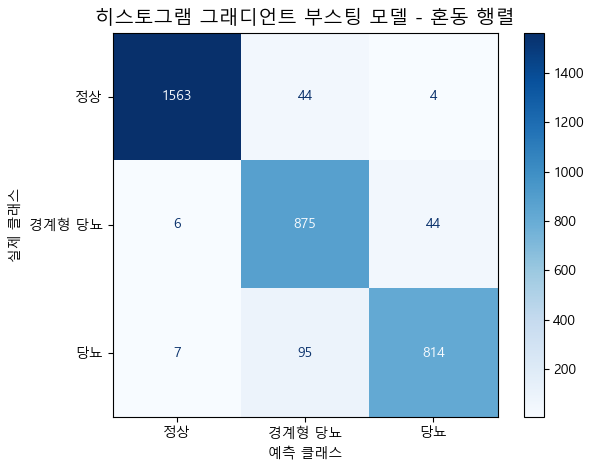

In [159]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_DM_HbA1c_input_features = ['HE_glu','HE_HbA1c', 'HE_wc', 'HE_BMI', 'HE_LDL_drct', 'age']

# X와 y 정의
X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred = best_model.predict(X_test_scaled)

# 클래스 이름 한글로 정의
target_names_kor = ['정상', '경계형 당뇨', '당뇨']

# 평가 지표 출력 (한글 클래스명)
print(classification_report(y_test, y_pred, target_names=target_names_kor))

print("=== 당뇨병 모델 성능 평가 ===")

# 훈련 세트 성능 평가
y_train_pred = best_model.predict(X_train_scaled) # SMOTE 적용 전의 스케일링된 훈련 데이터에 대한 예측
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
print("\n--- 훈련 세트 성능 ---")
print(f"훈련 정확도: {train_accuracy:.1f}%")
print(classification_report(y_train, y_train_pred, target_names=target_names_kor))

# 테스트 세트 성능 평가
y_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred) * 100
print("\n--- 테스트 세트 성능 ---")
print(f"테스트 정확도: {test_accuracy:.1f}%")
print(classification_report(y_test, y_pred, target_names=target_names_kor))

# 훈련 vs 테스트 정확도 비교
print("\n--- 훈련/테스트 정확도 비교 ---")
print(f"훈련 정확도: {train_accuracy:.1f}%")
print(f"테스트 정확도: {test_accuracy:.1f}%")
accuracy_diff = train_accuracy - test_accuracy
print(f"정확도 차이 (훈련 - 테스트): {accuracy_diff:.1f}p")
if accuracy_diff > 5: # 임의의 기준, 필요에 따라 조절
    print("-> 훈련 정확도가 테스트 정확도보다 현저히 높으므로 과적합 가능성이 있습니다.")
elif accuracy_diff < -5:
    print("-> 테스트 정확도가 훈련 정확도보다 현저히 높아 이상 징후일 수 있습니다 (데이터 유출 등 확인 필요).")
else:
    print("-> 훈련 및 테스트 정확도 차이가 크지 않아 과적합이 아닐 가능성이 높습니다.")


# 평가 지표 및 혼동행렬
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

# 혼동 행렬 시각화
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names_kor)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("히스토그램 그래디언트 부스팅 모델 - 혼동 행렬", fontsize=14)
plt.xlabel("예측 클래스")
plt.ylabel("실제 클래스")
plt.tight_layout()
plt.show()

# classification_report DataFrame 변환 (선택)
class_report = classification_report(y_test, y_pred, target_names=target_names_kor, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()



In [ ]:
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'HE_HbA1c'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data


print("결측치 처리 후 데이터 상태:")
print(data.isnull().sum())
print("\n타겟 변수 클래스 비율:")
for target in ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']:
    if target in data.columns:
        print(f"\n{target}:\n{data[target].value_counts(normalize=True)}")
print("\n기본 통계량:")
print(data.describe())

# 전처리 코드 끝에 추가
data.to_csv("최종_건강검진_데이터셋(가공된).csv", index=False, encoding='utf-8-sig')

Median for HE_wt: 62.9
Median for HE_ht: 162.7
Median for HE_BMI: 23.87374380540307
결측치 처리 후 데이터 상태:
ID                0
year              0
age               0
sex               0
HE_ht             0
HE_wt             0
HE_wc             0
HE_BMI            0
HE_sbp1           0
HE_dbp1           0
HE_Upro           0
HE_glu            0
HE_HbA1c          0
HE_chol           0
HE_HDL_st2        0
HE_TG             0
HE_LDL_drct       0
HE_crea           0
HE_ast            0
HE_alt            0
HE_obe            0
HE_HP             0
HE_DM_HbA1c       0
DE1_dg            0
DI1_dg            0
DE1_pt            0
DI1_pt            0
HE_BMI_imputed    0
dtype: int64

타겟 변수 클래스 비율:

HE_DM_HbA1c:
HE_DM_HbA1c
1.0    0.466810
2.0    0.268018
3.0    0.265172
Name: proportion, dtype: float64

HE_obe:
HE_obe
2.0    0.360822
4.0    0.291829
3.0    0.222835
5.0    0.054010
1.0    0.046518
6.0    0.023985
Name: proportion, dtype: float64

HE_HP:
HE_HP
1.0    0.336605
3.0    0.269818
4.0    0.2093

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 다중 클래스 (0: 정상, 1: 경계형, 2: 당뇨) → One-vs-Rest용 이진 매트릭스로 변환
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_proba = best_model.predict_proba(X_test_scaled)

# ROC AUC Score 계산 (macro)
roc_auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"Macro ROC AUC Score: {roc_auc_macro:.4f}")


Macro ROC AUC Score: 0.9896


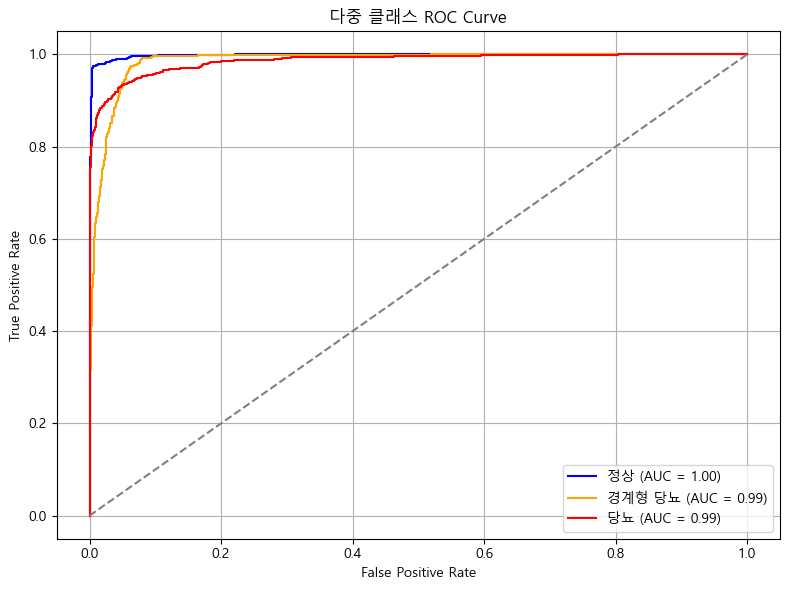

In [50]:
# 클래스 이름 한글
class_names = ['정상', '경계형 당뇨', '당뇨']
colors = ['blue', 'orange', 'red']

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("다중 클래스 ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_HP_input_features(고혈압 입력값)= ['age','HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 
                                'HE_BMI', 'HE_chol', 'HE_LDL_drct', 'HE_HbA1c']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 시각화
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='Cross-Validation F1')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='Test F1', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='Test Accuracy', alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('Score (%)')
plt.title('Model Comparison with Reduced Features')
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 Score (%)')
ax.set_title('Model F1 Score Distribution (Cross-Validation)')
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (4068120221.py, line 14)

**다중모델비교(고혈압)**


📌 HistGradientBoosting Classification Report:

              precision    recall  f1-score   support

          정상       0.88      0.83      0.85      1163
        주의혈압       0.67      0.75      0.71       635
      고혈압전단계       0.71      0.70      0.71       931
         고혈압       0.66      0.65      0.65       723

    accuracy                           0.74      3452
   macro avg       0.73      0.73      0.73      3452
weighted avg       0.75      0.74      0.74      3452



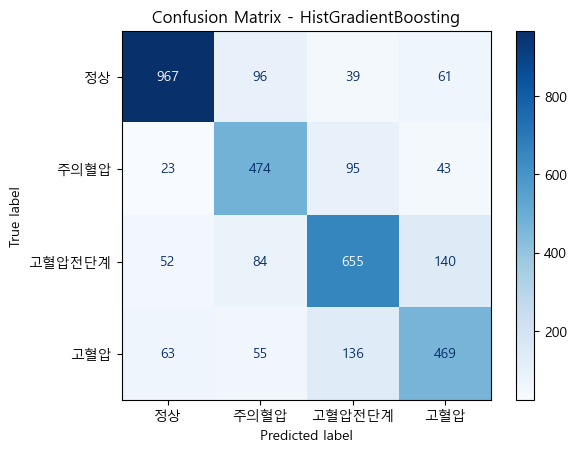


📌 XGBoost Classification Report:

              precision    recall  f1-score   support

          정상       0.84      0.86      0.85      1163
        주의혈압       0.70      0.71      0.71       635
      고혈압전단계       0.69      0.73      0.71       931
         고혈압       0.67      0.59      0.63       723

    accuracy                           0.74      3452
   macro avg       0.73      0.72      0.72      3452
weighted avg       0.74      0.74      0.74      3452



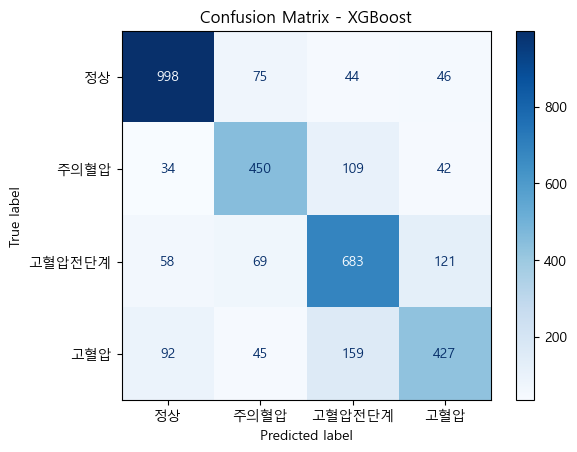


📌 RandomForest Classification Report:

              precision    recall  f1-score   support

          정상       0.85      0.86      0.85      1163
        주의혈압       0.69      0.72      0.70       635
      고혈압전단계       0.68      0.74      0.71       931
         고혈압       0.67      0.56      0.61       723

    accuracy                           0.74      3452
   macro avg       0.72      0.72      0.72      3452
weighted avg       0.74      0.74      0.74      3452



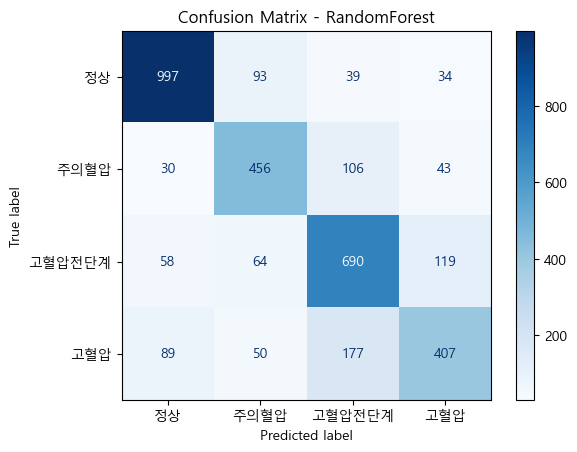

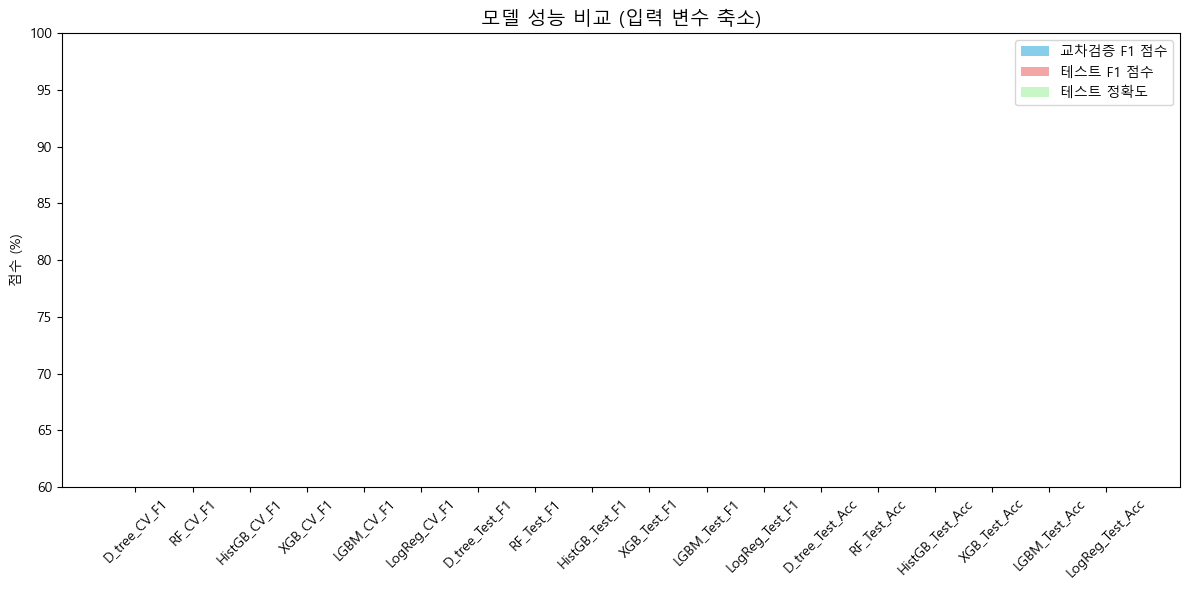

  0%|          | 0/100 [00:00<?, ?it/s]

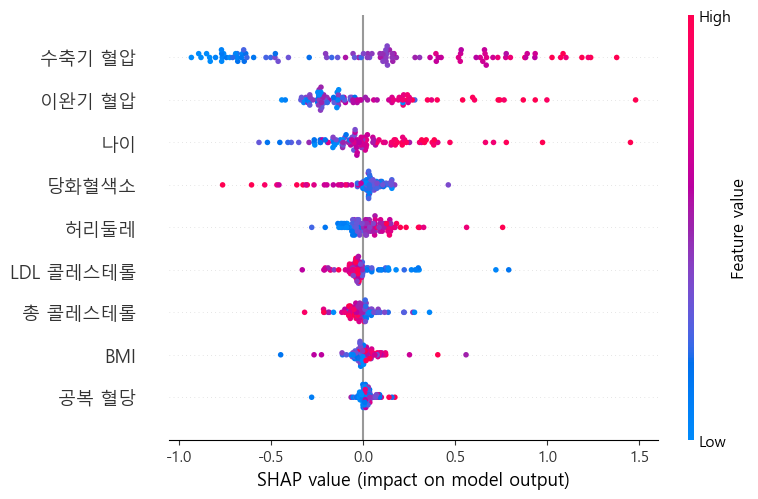

In [178]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# 🎯 사용할 피처와 타겟
features= ['age','HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_chol', 'HE_LDL_drct', 'HE_HbA1c']
X = data[features]
y = data['HE_HP'].astype(int) - 1  # 0: 정상, 1: 경계형, 2: 당뇨

# ⚙️ 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 🔧 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 📦 모델 정의
models = {
    "HistGradientBoosting": HistGradientBoostingClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softprob', num_class=3, use_label_encoder=False,
                             eval_metric='mlogloss', scale_pos_weight=1, random_state=42),
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42)
}

# 🔍 모델 훈련 & 평가
for name, model in models.items():
    if name == "XGBoost":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    print(f"\n📌 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=['정상', '주의혈압', '고혈압전단계', '고혈압']))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['정상', '주의혈압', '고혈압전단계', '고혈압'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# 성능 바 차트 (CV, Test F1, Test Accuracy)
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='교차검증 F1 점수')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='테스트 F1 점수', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='테스트 정확도', alpha=0.5)

plt.xticks(rotation=45)
plt.ylabel('점수 (%)')
plt.title('모델 성능 비교 (입력 변수 축소)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

korean_features = [
    '나이', '수축기 혈압', '이완기 혈압', '허리둘레', '공복 혈당', 'BMI',
    '총 콜레스테롤', 'LDL 콜레스테롤', '당화혈색소'
]

# ✅ SHAP 해석 (KernelExplainer 사용)
# HistGradientBoosting 기준 해석
explainer = shap.KernelExplainer(models["HistGradientBoosting"].predict, X_train_scaled[:100])  # 100개만 추출로 속도 개선
shap_values = explainer.shap_values(X_test_scaled[:100])

# 시각화
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=korean_features)



| 피처명                       | 영향도  | 해석 요약            |
| ------------------------- | ---- | ---------------- |
| `HE_sbp1 (수축기 혈압)`        | 매우 큼 | 높을수록 고혈압 예측 ↑    |
| `HE_dbp1 (이완기 혈압)`        | 매우 큼 | 높을수록 고혈압 예측 ↑    |
| `age (나이)`                | 중간   | 고령일수록 고혈압 예측 ↑   |
| `HE_HbA1c (당화혈색소)`        | 중간   | 높을수록 고혈압 예측 약간 ↑ |
| `HE_wc (허리둘레)`            | 낮음   | 예측 영향 작음         |
| `HE_LDL_drct (LDL 콜레스테롤)` | 낮음   | 낮을수록 고혈압 아님 가능 ↑ |
| `HE_chol (총 콜레스테롤)`       | 낮음   | 예측 영향 작음         |
| `HE_BMI (체질량지수)`          | 낮음   | 예측 영향 작음         |
| `HE_glu (공복 혈당)`          | 낮음   | 예측 영향 작음         |


In [ ]:
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'HE_HbA1c'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data


print("결측치 처리 후 데이터 상태:")
print(data.isnull().sum())
print("\n타겟 변수 클래스 비율:")
for target in ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']:
    if target in data.columns:
        print(f"\n{target}:\n{data[target].value_counts(normalize=True)}")
print("\n기본 통계량:")
print(data.describe())

# 전처리 코드 끝에 추가
data.to_csv("최종_건강검진_데이터셋(가공된).csv", index=False, encoding='utf-8-sig')

Median for HE_wt: 62.9
Median for HE_ht: 162.7
Median for HE_BMI: 23.87374380540307
결측치 처리 후 데이터 상태:
ID                0
year              0
age               0
sex               0
HE_ht             0
HE_wt             0
HE_wc             0
HE_BMI            0
HE_sbp1           0
HE_dbp1           0
HE_Upro           0
HE_glu            0
HE_HbA1c          0
HE_chol           0
HE_HDL_st2        0
HE_TG             0
HE_LDL_drct       0
HE_crea           0
HE_ast            0
HE_alt            0
HE_obe            0
HE_HP             0
HE_DM_HbA1c       0
DE1_dg            0
DI1_dg            0
DE1_pt            0
DI1_pt            0
HE_BMI_imputed    0
dtype: int64

타겟 변수 클래스 비율:

HE_DM_HbA1c:
HE_DM_HbA1c
1.0    0.466810
2.0    0.268018
3.0    0.265172
Name: proportion, dtype: float64

HE_obe:
HE_obe
2.0    0.360822
4.0    0.291829
3.0    0.222835
5.0    0.054010
1.0    0.046518
6.0    0.023985
Name: proportion, dtype: float64

HE_HP:
HE_HP
1.0    0.336605
3.0    0.269818
4.0    0.2093


--- HistGradientBoosting 분류 리포트 ---
              precision    recall  f1-score   support

          정상       0.87      0.84      0.85      1163
       주의 혈압       0.68      0.74      0.71       635
     고혈압 전단계       0.70      0.72      0.71       931
         고혈압       0.64      0.61      0.63       723

    accuracy                           0.74      3452
   macro avg       0.72      0.73      0.72      3452
weighted avg       0.74      0.74      0.74      3452



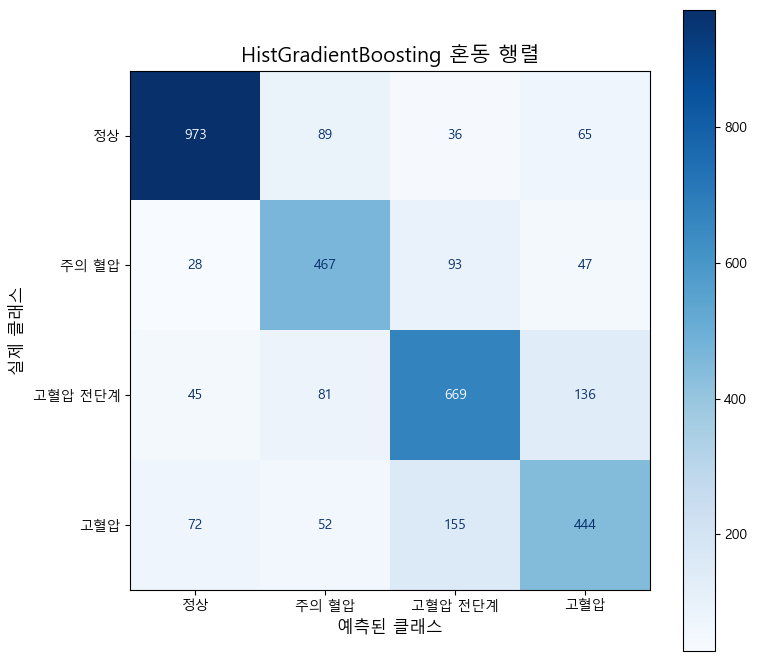

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 설정 (나눔고딕 또는 시스템에 설치된 한글 폰트 경로로 변경하세요)
# 예시: 'NanumGothic.ttf' 또는 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
try:
    fm.fontManager.addfont('C:/Windows/Fonts/malgun.ttf') # Windows 사용자
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지
except:
    print("맑은 고딕 폰트를 찾을 수 없습니다. 다른 한글 폰트를 설정하거나 설치하세요.")



# 입력 피처 및 타겟 설정
HE_HP_input_features= ['age(나이)','HE_sbp1(수축기혈압)', 'HE_dbp1(이완기혈압)',  'HE_wc(허리둘레)', 'HE_glu(공복혈당)', 
                       'HE_BMI', 'HE_chol(총콜레스테롤)', 'HE_LDL_drct(LDL콜레스테롤)', 'HE_HbA1c(당화혈색소)']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1 # 0:정상, 1:경계형, 2:당뇨 (코드상 3단계로만 분류하고 있으므로, target_names를 3개로 맞춥니다.)

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test) # 테스트 데이터에는 transform만 적용

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# HistGradientBoostingClassifier로 모델 훈련 및 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred = best_model.predict(X_test_scaled)

# 클래스 이름 정의 (y=data['HE_HP'].astype(int) - 1 에 따라 0, 1, 2)
# 'HE_HP'가 1, 2, 3으로 나뉘어 있다면, -1을 하면 0, 1, 2가 됩니다.
# 따라서 target_names는 3개여야 합니다.
class_names_korean = ['정상', '주의 혈압', '고혈압 전단계', '고혈압']


# 분류 리포트 출력 (한글 타겟 이름 적용)
print("\n--- HistGradientBoosting 분류 리포트 ---")
print(classification_report(y_test, y_pred, target_names=class_names_korean))

# 혼동 행렬 시각화 (한글 라벨 적용)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 7)) # 플롯 사이즈 조정
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names_korean)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca()) # ax=plt.gca()를 사용하여 현재 figure에 플롯
plt.title("HistGradientBoosting 혼동 행렬", fontsize=15)
plt.xlabel("예측된 클래스", fontsize=12) # X축 라벨 한글화
plt.ylabel("실제 클래스", fontsize=12) # Y축 라벨 한글화
plt.tight_layout()
plt.show()

smote 전 후 시각화

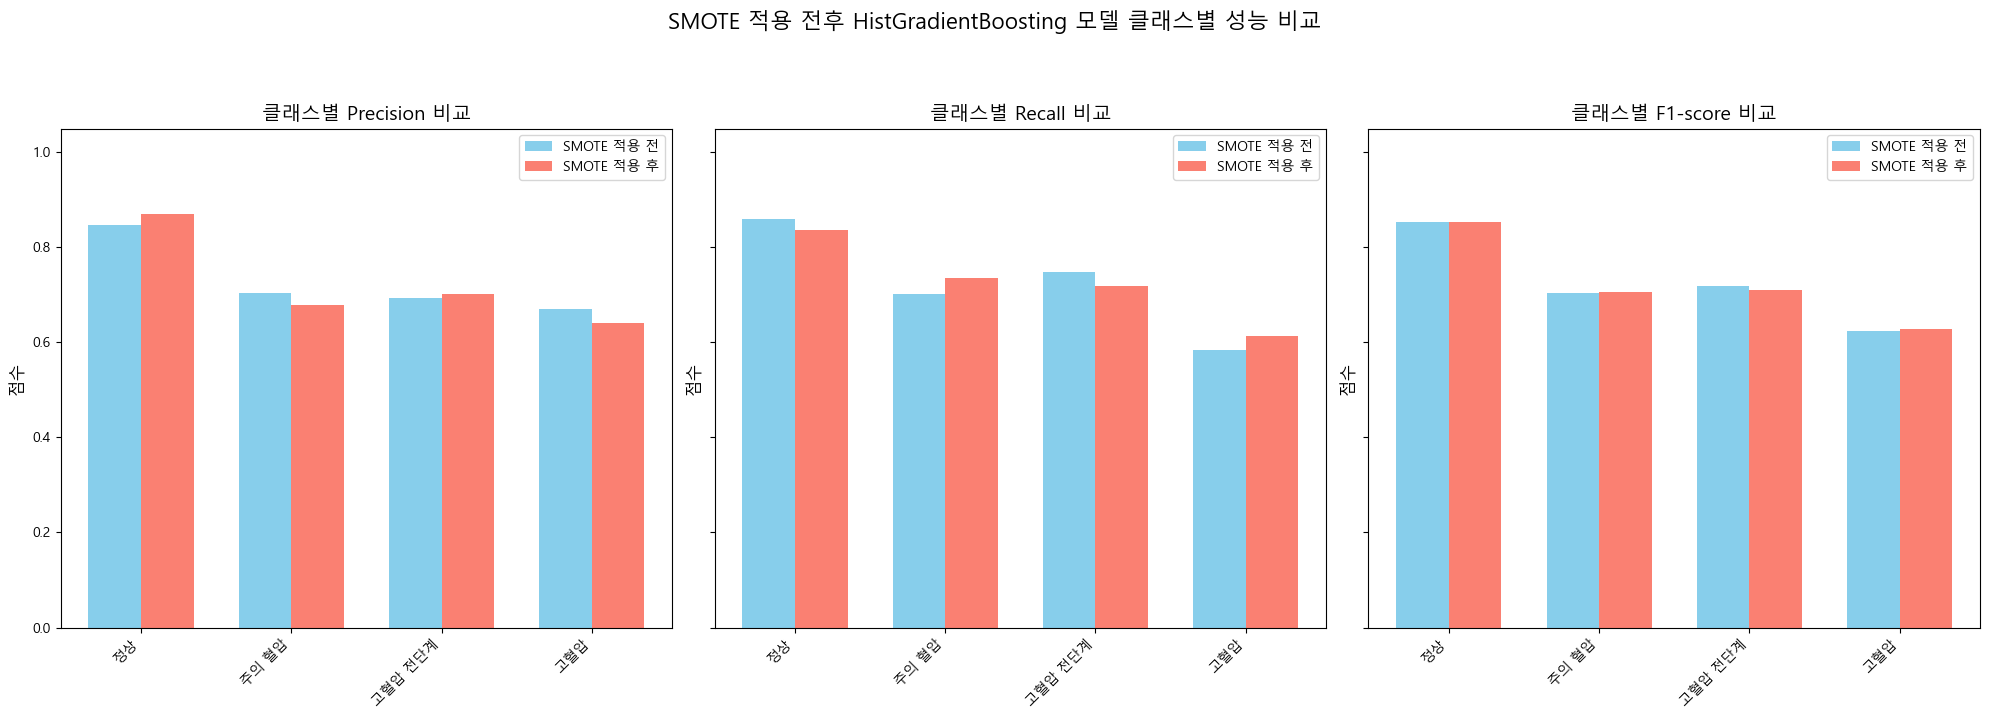

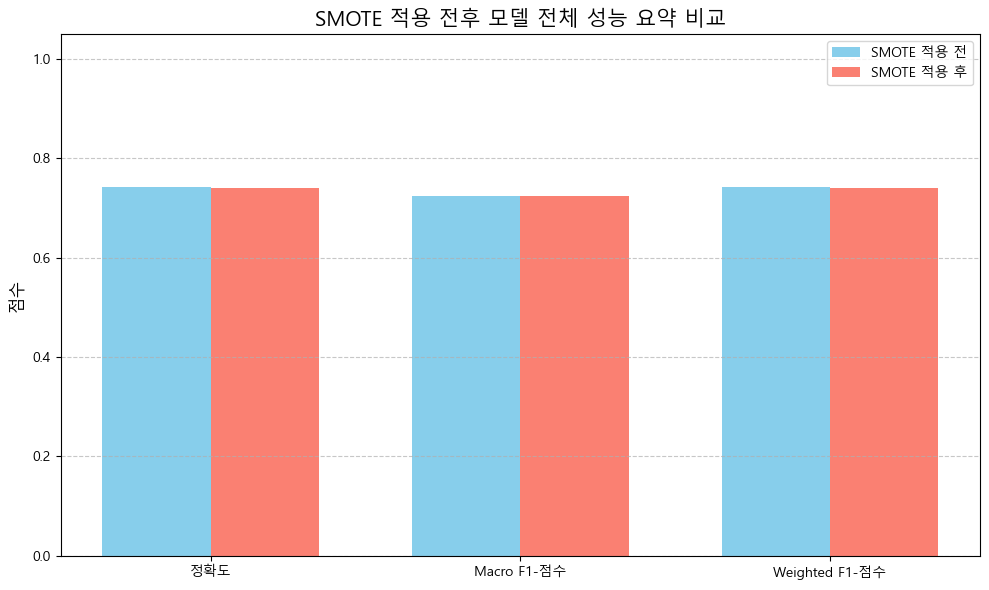

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# 입력 피처 및 타겟 설정
HE_HP_input_features = ['age','HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_BMI', 'HE_chol', 'HE_LDL_drct', 'HE_HbA1c']

# X와 y 정의 (0:정상, 1:경계형, 2:당뇨)
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1
class_names_korean = ['정상', '주의 혈압', '고혈압 전단계', '고혈압']

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- SMOTE 적용 전 모델 훈련 및 평가 ---
model_before_smote = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
model_before_smote.fit(X_train_scaled, y_train)
y_pred_before_smote = model_before_smote.predict(X_test_scaled)
report_before_smote = classification_report(y_test, y_pred_before_smote, target_names=class_names_korean, output_dict=True)

# --- SMOTE 적용 후 모델 훈련 및 평가 ---
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
model_after_smote = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
model_after_smote.fit(X_train_smote, y_train_smote)
y_pred_after_smote = model_after_smote.predict(X_test_scaled)
report_after_smote = classification_report(y_test, y_pred_after_smote, target_names=class_names_korean, output_dict=True)


# --- SMOTE 적용 전후 성능 지표 비교 시각화 (막대 그래프) ---

# 1. 각 클래스별 정밀도(Precision), 재현율(Recall), F1-점수(F1-Score) 비교
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True) # 3개의 서브플롯 생성, Y축 공유

metrics_to_plot = ['precision', 'recall', 'f1-score']
colors = ['skyblue', 'salmon'] # SMOTE 적용 전, SMOTE 적용 후

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    # 각 클래스별 'SMOTE 적용 전'의 지표 값 추출
    before_values = [report_before_smote[c][metric] for c in class_names_korean]
    # 각 클래스별 'SMOTE 적용 후'의 지표 값 추출
    after_values = [report_after_smote[c][metric] for c in class_names_korean]

    x = np.arange(len(class_names_korean)) # 각 클래스에 대한 X축 위치
    width = 0.35 # 막대 너비

    # 'SMOTE 적용 전' 막대
    rects1 = ax.bar(x - width/2, before_values, width, label='SMOTE 적용 전', color=colors[0])
    # 'SMOTE 적용 후' 막대
    rects2 = ax.bar(x + width/2, after_values, width, label='SMOTE 적용 후', color=colors[1])

    ax.set_title(f'클래스별 {metric.capitalize()} 비교', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names_korean, rotation=45, ha='right') # 클래스 라벨 회전
    ax.set_ylabel('점수', fontsize=12)
    ax.legend(fontsize=10)
    ax.set_ylim(0, 1.05) # Y축 범위 (0에서 100%까지)

plt.suptitle('SMOTE 적용 전후 HistGradientBoosting 모델 클래스별 성능 비교', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # 전체 제목을 위한 공간 확보
plt.show()

# 2. 전체 모델의 정확도(Accuracy), Macro F1, Weighted F1 비교
overall_metrics_labels = ['정확도', 'Macro F1-점수', 'Weighted F1-점수']
overall_metrics_before = [
    report_before_smote['accuracy'],
    report_before_smote['macro avg']['f1-score'],
    report_before_smote['weighted avg']['f1-score']
]
overall_metrics_after = [
    report_after_smote['accuracy'],
    report_after_smote['macro avg']['f1-score'],
    report_after_smote['weighted avg']['f1-score']
]

x = np.arange(len(overall_metrics_labels))
width = 0.35

plt.figure(figsize=(10, 6))
# 'SMOTE 적용 전' 막대
plt.bar(x - width/2, overall_metrics_before, width, label='SMOTE 적용 전', color='skyblue')
# 'SMOTE 적용 후' 막대
plt.bar(x + width/2, overall_metrics_after, width, label='SMOTE 적용 후', color='salmon')

plt.ylabel('점수', fontsize=12)
plt.title('SMOTE 적용 전후 모델 전체 성능 요약 비교', fontsize=15)
plt.xticks(x, overall_metrics_labels, rotation=0)
plt.ylim(0, 1.05) # Y축 범위 (0에서 100%까지)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Y축에 그리드 라인 추가
plt.tight_layout()
plt.show()

# (선택 사항) 혼동 행렬도 각각 시각화하여 비교하는 것도 여전히 유용합니다.
# 위에 이미 코드가 있으므로 여기서는 생략합니다.
# conf_matrix_before = confusion_matrix(y_test, y_pred_before_smote)
# disp_before = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_before, display_labels=class_names_korean)
# disp_before.plot(cmap=plt.cm.Blues)
# plt.title("SMOTE 적용 전 혼동 행렬")
# plt.show()

# conf_matrix_after = confusion_matrix(y_test, y_pred_after_smote)
# disp_after = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_after, display_labels=class_names_korean)
# disp_after.plot(cmap=plt.cm.Blues)
# plt.title("SMOTE 적용 후 혼동 행렬")
# plt.show()

In [181]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 다중 클래스 (0: 정상, 1: 주의혈압, 2: 고혈압전단계, 3:고혈압) → One-vs-Rest용 이진 매트릭스로 변환
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_proba = best_model.predict_proba(X_test_scaled)

# ROC AUC Score 계산 (macro)
roc_auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"Macro ROC AUC Score: {roc_auc_macro:.4f}")


Macro ROC AUC Score: 0.9228


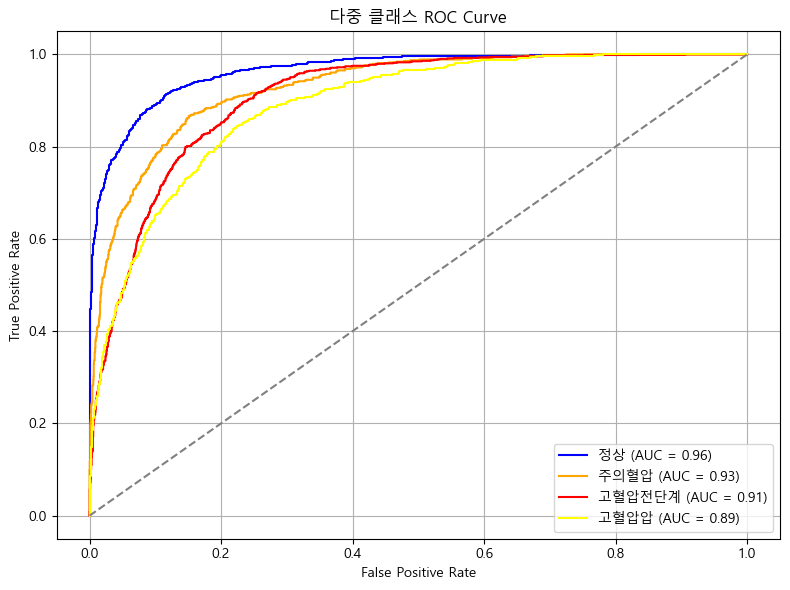

In [ ]:
# 클래스 이름 한글
class_names = ['정상', '주의혈압', '고혈압전단계', '고혈압']
colors = ['blue', 'orange', 'red', 'yellow']

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("다중 클래스 ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


▶ Mean F1 score (CV) of D_tree: 58.29%
▶ Test F1 score of D_tree: 56.43%
▶ Test Accuracy of D_tree: 66.34%

▶ Mean F1 score (CV) of RF: 97.02%
▶ Test F1 score of RF: 97.19%
▶ Test Accuracy of RF: 97.29%

▶ Mean F1 score (CV) of HistGB: 99.23%
▶ Test F1 score of HistGB: 97.90%
▶ Test Accuracy of HistGB: 97.90%

▶ Mean F1 score (CV) of XGB: 98.92%
▶ Test F1 score of XGB: 98.98%
▶ Test Accuracy of XGB: 98.98%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 10968, number of used features: 7
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791760
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start trainin

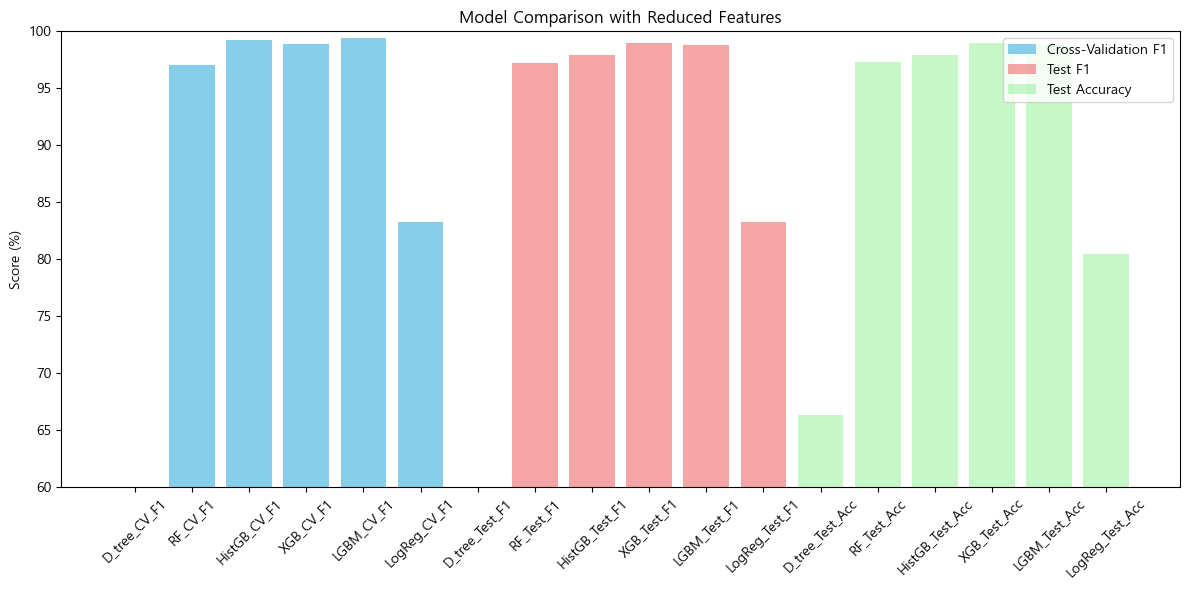

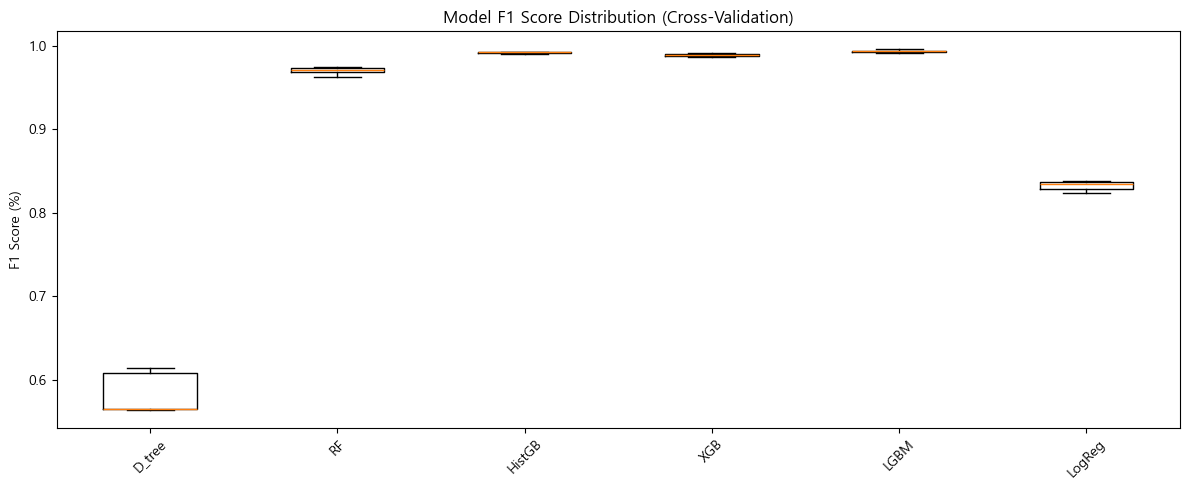

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# 입력 피처 및 타겟 설정
HE_obe_input_features= ['age','HE_wc', 'HE_BMI',  'HE_wt', 'HE_alt', 'HE_HDL_st2', 'HE_TG']

# X와 y 정의
X = data[HE_obe_input_features]
y = data['HE_obe'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 시각화
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='Cross-Validation F1')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='Test F1', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='Test Accuracy', alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('Score (%)')
plt.title('Model Comparison with Reduced Features')
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 Score (%)')
ax.set_title('Model F1 Score Distribution (Cross-Validation)')
plt.tight_layout()
plt.show()



📌 HistGradientBoosting Classification Report:

              precision    recall  f1-score   support

         저체중       1.00      1.00      1.00       161
        정상체중       1.00      1.00      1.00      1246
         과체중       0.99      0.96      0.98       769
          비만       0.99      1.00      0.99      1007
        고도비만       0.96      0.99      0.98       186
      초고도비만        0.84      0.95      0.89        83

    accuracy                           0.99      3452
   macro avg       0.96      0.98      0.97      3452
weighted avg       0.99      0.99      0.99      3452



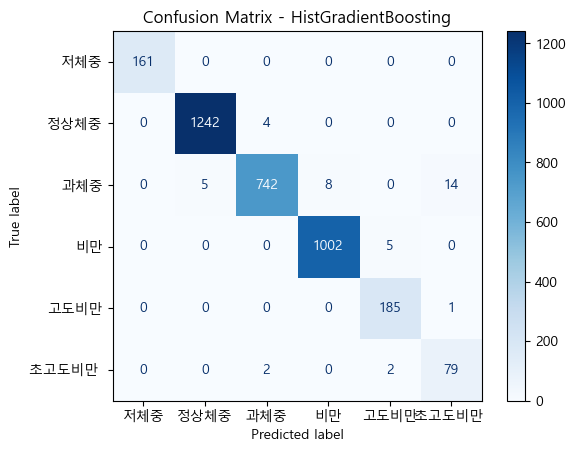


📌 XGBoost Classification Report:

              precision    recall  f1-score   support

         저체중       1.00      1.00      1.00       161
        정상체중       1.00      1.00      1.00      1246
         과체중       0.99      0.98      0.99       769
          비만       0.99      1.00      0.99      1007
        고도비만       0.97      0.99      0.98       186
      초고도비만        0.94      0.94      0.94        83

    accuracy                           0.99      3452
   macro avg       0.98      0.98      0.98      3452
weighted avg       0.99      0.99      0.99      3452



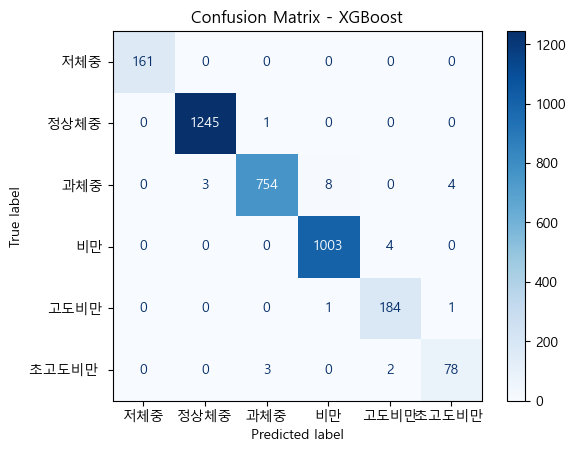


📌 RandomForest Classification Report:

              precision    recall  f1-score   support

         저체중       1.00      1.00      1.00       161
        정상체중       1.00      1.00      1.00      1246
         과체중       0.98      0.99      0.98       769
          비만       1.00      1.00      1.00      1007
        고도비만       0.98      0.99      0.99       186
      초고도비만        0.94      0.77      0.85        83

    accuracy                           0.99      3452
   macro avg       0.98      0.96      0.97      3452
weighted avg       0.99      0.99      0.99      3452



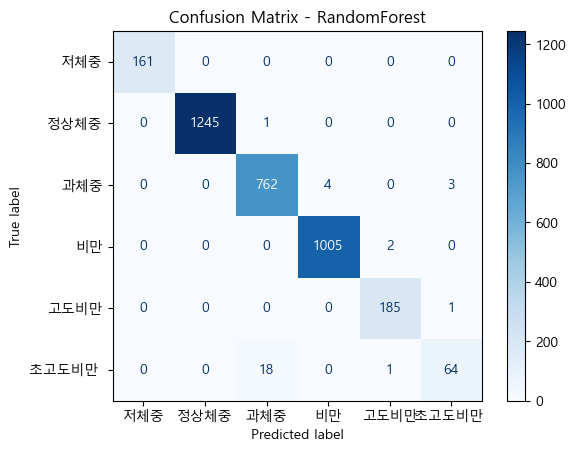

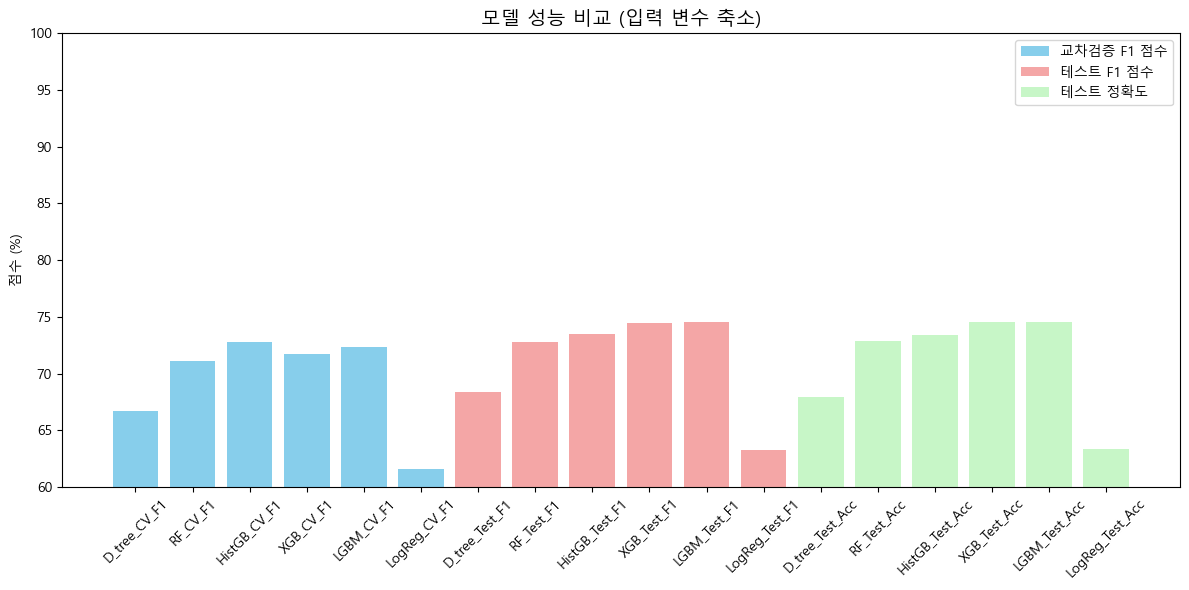

  0%|          | 0/100 [00:00<?, ?it/s]

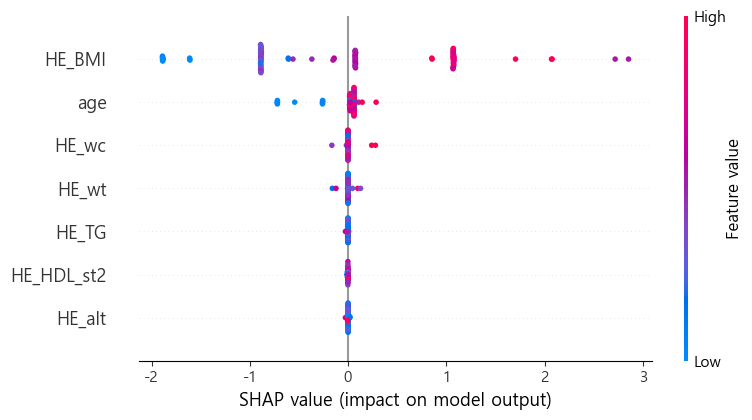

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# 🎯 사용할 피처와 타겟
features= ['age','HE_wc(허리둘레)', 'HE_BMI',  'HE_wt(무게)', 'HE_alt(간기능alt)', 'HE_HDL_st2(HDL콜레스테롤)', 'HE_TG(중성지방)']
X = data[features]
y = data['HE_obe'].astype(int) - 1 

# ⚙️ 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 🔧 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 📦 모델 정의
models = {
    "HistGradientBoosting": HistGradientBoostingClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softprob', num_class=3, use_label_encoder=False,
                             eval_metric='mlogloss', scale_pos_weight=1, random_state=42),
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42)
}

# 🔍 모델 훈련 & 평가
for name, model in models.items():
    if name == "XGBoost":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    print(f"\n📌 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=['저체중', '정상체중', '과체중', '비만', '고도비만', '초고도비만 ']))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['저체중', '정상체중', '과체중', '비만', '고도비만', '초고도비만 '])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# 성능 바 차트 (CV, Test F1, Test Accuracy)
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='교차검증 F1 점수')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='테스트 F1 점수', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='테스트 정확도', alpha=0.5)

plt.xticks(rotation=45)
plt.ylabel('점수 (%)')
plt.title('모델 성능 비교 (입력 변수 축소)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ SHAP 해석 (KernelExplainer 사용)
# HistGradientBoosting 기준 해석
explainer = shap.KernelExplainer(models["HistGradientBoosting"].predict, X_train_scaled[:100])  # 100개만 추출로 속도 개선
shap_values = explainer.shap_values(X_test_scaled[:100])

# 시각화
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=features)


                 precision    recall  f1-score   support

  Class 0 (저체중)       0.99      0.98      0.98       161
Class 1 (정상 체중)       0.99      1.00      0.99      1246
  Class 2 (과체중)       1.00      0.97      0.98       769
   Class 3 (비만)       0.99      0.99      0.99      1007
 Class 4 (고도비만)       0.96      0.98      0.97       186
Class 5 (초고도비만)       0.90      0.99      0.94        83

       accuracy                           0.99      3452
      macro avg       0.97      0.99      0.98      3452
   weighted avg       0.99      0.99      0.99      3452



<Figure size 600x600 with 0 Axes>

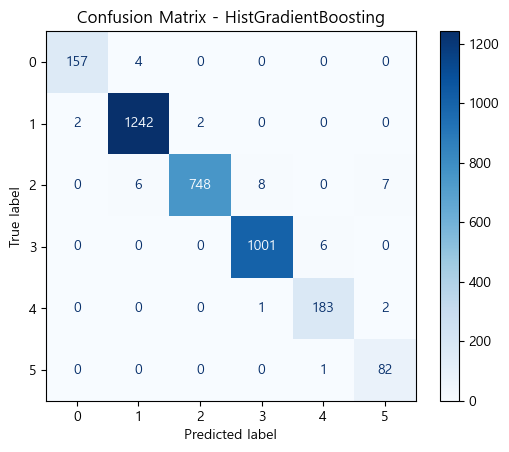

In [189]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_obe_input_features= ['age','HE_wc', 'HE_BMI',  'HE_wt', 'HE_alt', 'HE_HDL_st2', 'HE_TG']

# X와 y 정의
X = data[HE_obe_input_features]
y = data['HE_obe'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred = best_model.predict(X_test_scaled)

# 클래스별 F1 스코어 출력
print(classification_report(y_test, y_pred, target_names=['Class 0 (저체중)', 'Class 1 (정상 체중)', 'Class 2 (과체중)',
                                                          'Class 3 (비만)', 'Class 4 (고도비만)', 'Class 5 (초고도비만)']))

# 평가 지표 및 혼동행렬
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

# 시각화
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - HistGradientBoosting")
plt.show()

In [190]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
y_proba = best_model.predict_proba(X_test_scaled)

# ROC AUC Score 계산 (macro)
roc_auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"Macro ROC AUC Score: {roc_auc_macro:.4f}")


Macro ROC AUC Score: 0.9996


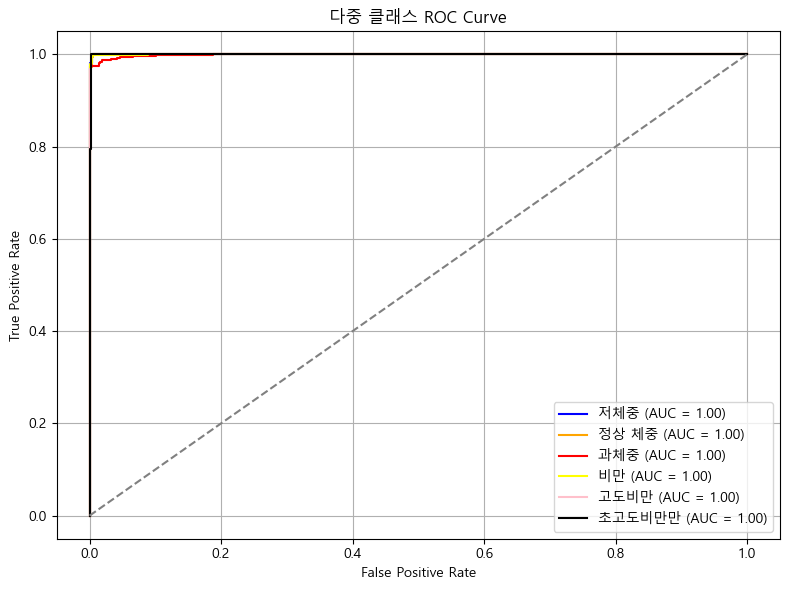

In [191]:
# 클래스 이름 한글
class_names = ['저체중', '정상 체중', '과체중', '비만', '고도비만', '초고도비만만']
colors = ['blue', 'orange', 'red', 'yellow', 'pink', 'black']

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
for i in range(6):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("다중 클래스 ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()